In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors as col
from matplotlib.dates import DateFormatter
import cycler
import seaborn as sns
from scipy.signal import savgol_filter
plt.style.use('seaborn')


In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]            
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

In [25]:
def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions
            
def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp
    
def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp  
    
def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal
    
def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal
        
def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    

In [4]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
test_file_name = '210420_green_tests/green_testing_210420.h5'

In [5]:
df = pd.read_csv('data/white_insertions.csv')

In [6]:
today_df = df.loc[df['date'] == '4/26/21'].copy()

In [7]:
this_morning_df = today_df.loc[today_df['session'] == 'session001'].copy()

## Plot of raw spectra, 4/26/21 morning

In this morning data collection session, the collection was done in the garage.  Collection began with a cold light source, but would otherwise be stable.

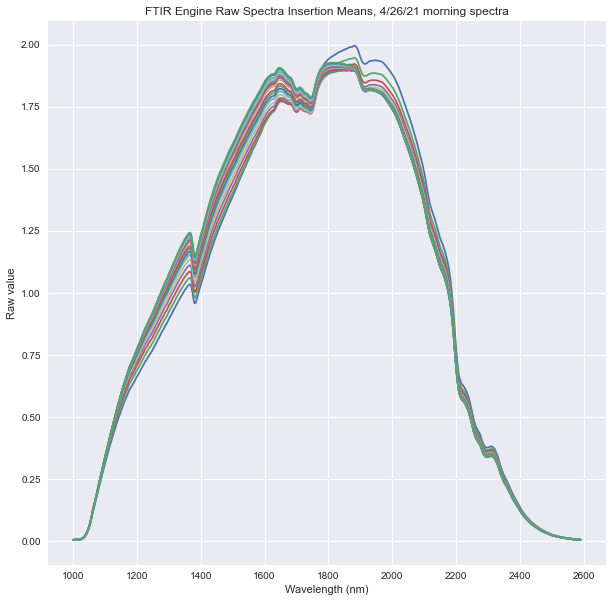

In [8]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("FTIR Engine Raw Spectra Insertion Means, 4/26/21 morning spectra")
ax.set_ylabel("Raw value")
ax.set_xlabel("Wavelength (nm)")
for index in this_morning_df.index:    
    file = construct_full_file_path(path_name, this_morning_df['file_name'][index])
    calibration_path = this_morning_df['session'][index] + '/' + this_morning_df['calibration'][index]
    insertion_path = calibration_path + '/' + this_morning_df['insertion'][index]
    insertion_temperature = get_insertion_temperature(file, insertion_path)
    ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
    calibration_spectrum = get_ftir_white_calibration_curve(file, calibration_path)
    ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)    
    ax.plot(ftir_waves, ftir_raw_spectra.mean(axis=0))
plt.show()
plt.close()    

# Plot of FTIR raw spectra for each date

The raw spectra are plotted by insertion means for each date.

Color is determined by the conditions under which the spectra were acquired.  "General" means that no special conditions were noted.  Some were taken inside the garage, some were taken just after the lamp was turned on, some taken outside in the cold, some taken outside in the sun, some taken outside in the sun but protected with the white box.

Usually those acquired "inside" would not involve much change for spectrometer or light source, but on 4/22 the "inside" spectra were taken as the spectrometer warmed inside after being out in the cold.

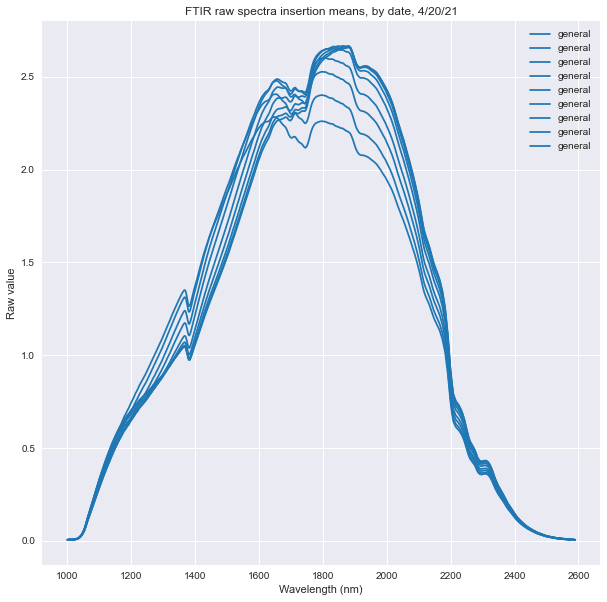

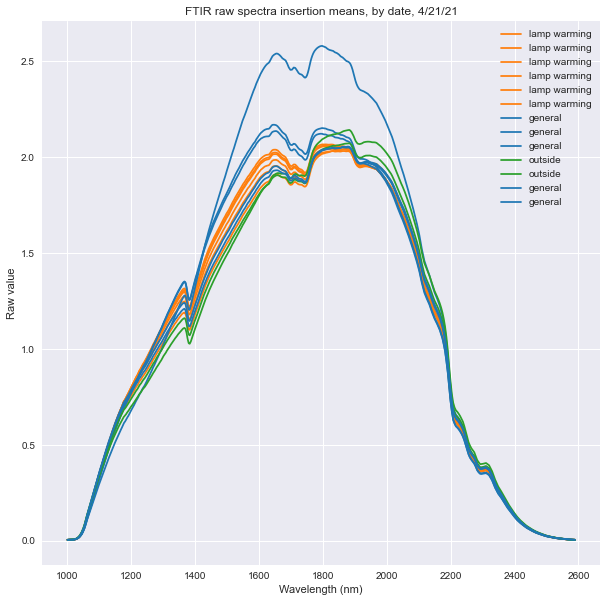

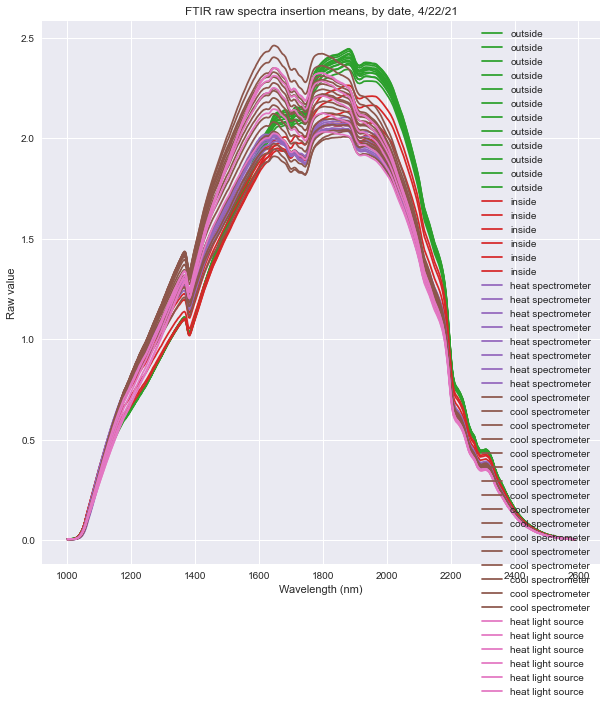

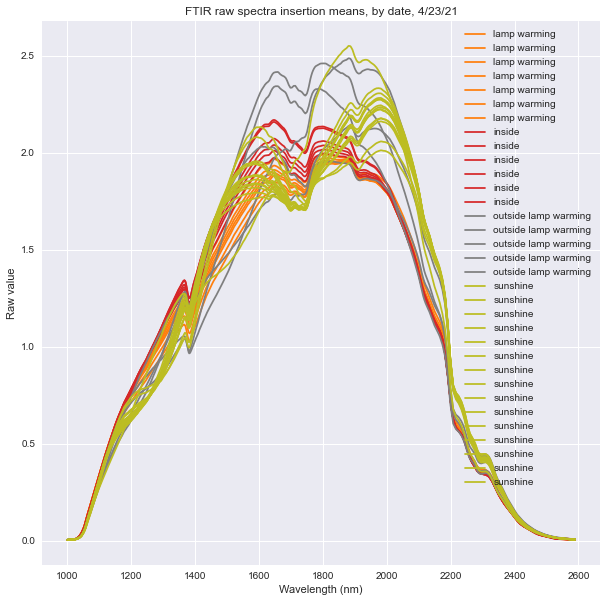

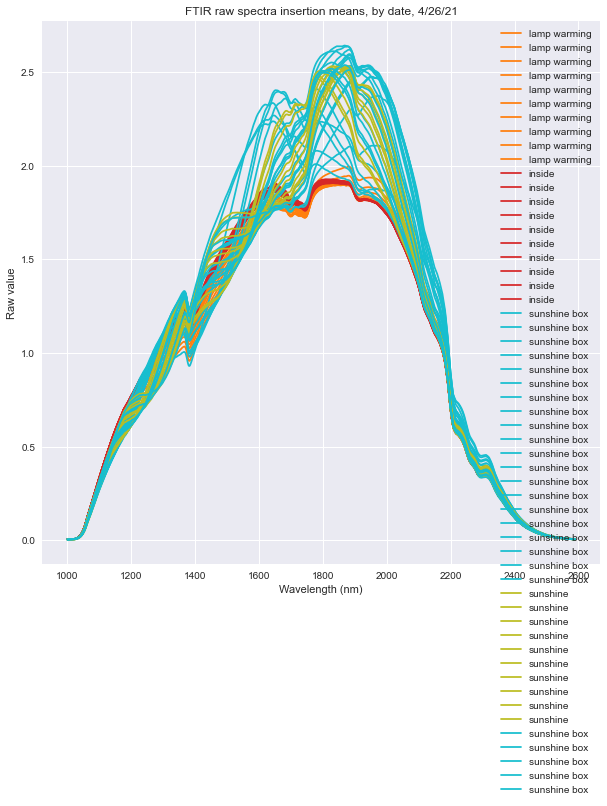

In [9]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
n = df['conditions'].unique().shape[0]
labels = df['conditions'].unique().tolist()
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.tab10.colors)
for date in df['date'].unique():
    small_df = df.loc[df['date'] == date].copy()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_ylabel("Raw value")
    ax.set_xlabel("Wavelength (nm)")
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]        
        insertion_temperature = get_insertion_temperature(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        calibration_spectrum = get_ftir_white_calibration_curve(file, calibration_path)
        ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
        date = small_df['date'][index]
        title = f"FTIR raw spectra insertion means, by date, {date}"
        condition = small_df['conditions'][index]
        label = labels[labels.index(condition)]
        color = "C" + str(labels.index(condition))
        
        ax.set_title(title)
        ax.plot(ftir_waves, ftir_raw_spectra.mean(axis=0), color=color, label=label)
    
    ax.legend()
    plt.show()
    plt.close()
    

# Plot of visible raw spectra for each date.

Same methods as for the FTIR engine spectra in the previous cell.  These are difficult to see the variation in.

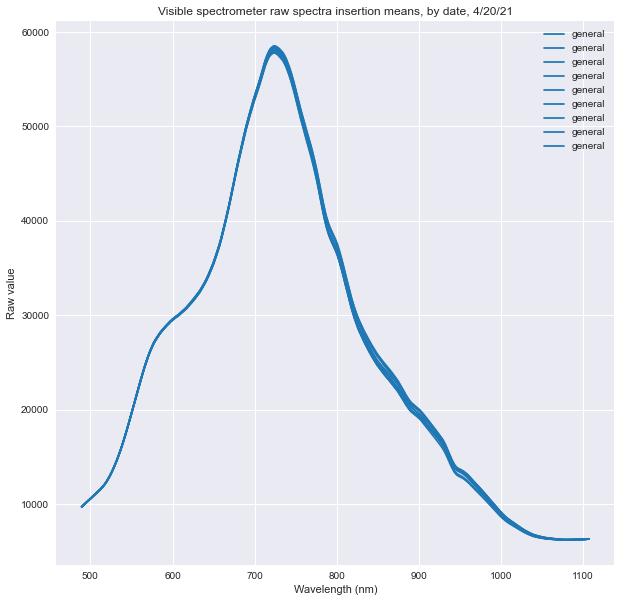

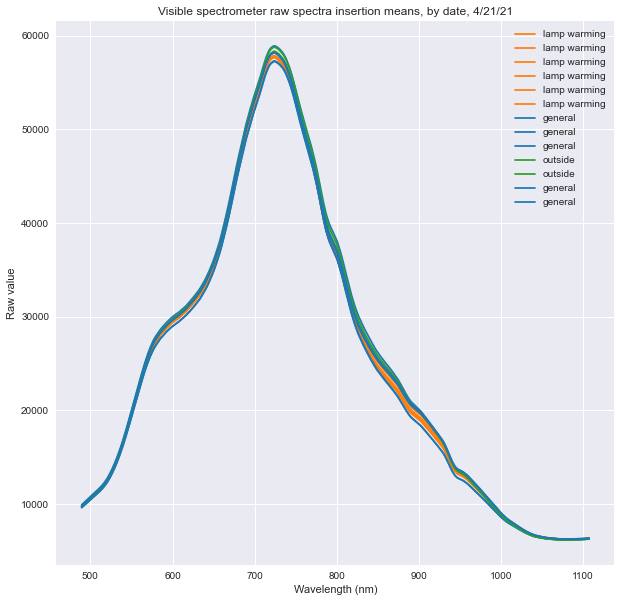

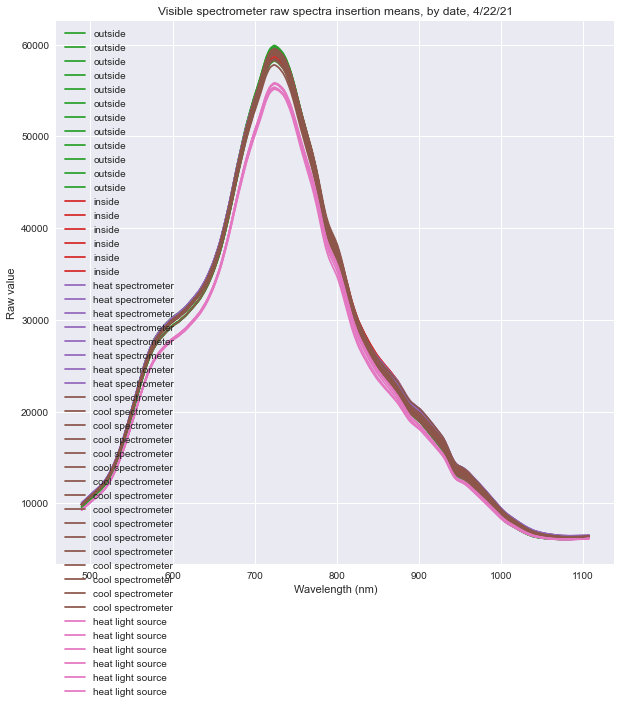

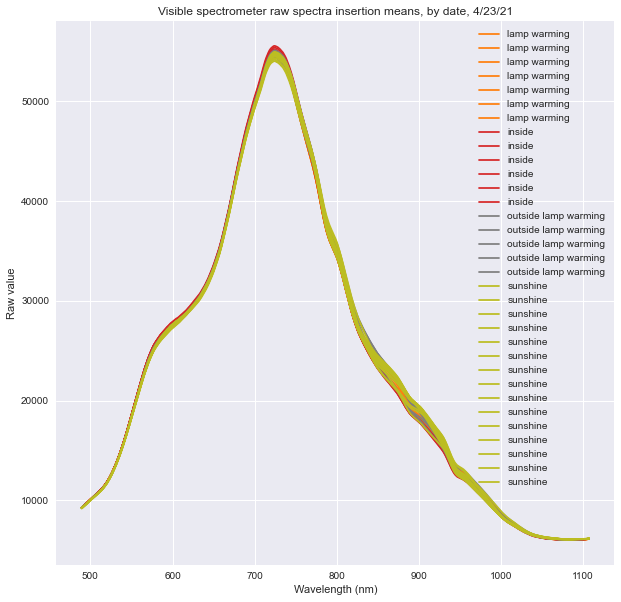

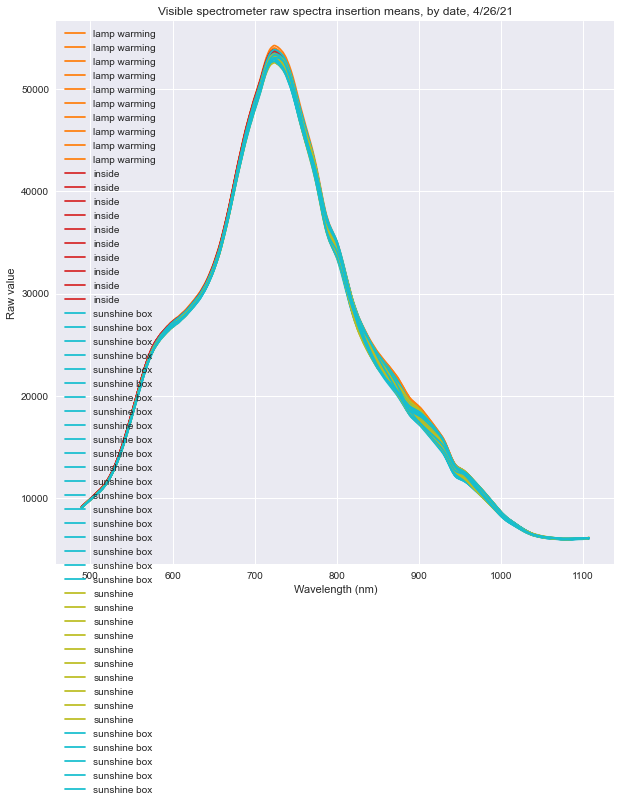

In [10]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
n = df['conditions'].unique().shape[0]
labels = df['conditions'].unique().tolist()
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.tab10.colors)
for date in df['date'].unique():
    small_df = df.loc[df['date'] == date].copy()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_ylabel("Raw value")
    ax.set_xlabel("Wavelength (nm)")
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]        
        insertion_temperature = get_insertion_temperature(file, insertion_path)
        vis_waves = get_visible_wavelength_vector(file, calibration_path)
        calibration_spectrum = get_visible_white_calibration_curve(file, calibration_path)
        vis_raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)
        date = small_df['date'][index]
        title = f"Visible spectrometer raw spectra insertion means, by date, {date}"
        condition = small_df['conditions'][index]
        label = labels[labels.index(condition)]
        color = "C" + str(labels.index(condition))
        
        ax.set_title(title)
        ax.plot(vis_waves, savgol_filter(vis_raw_spectra.mean(axis=0), 21, 3), color=color, label=label)
    ax.legend()
    plt.show()
    plt.close()

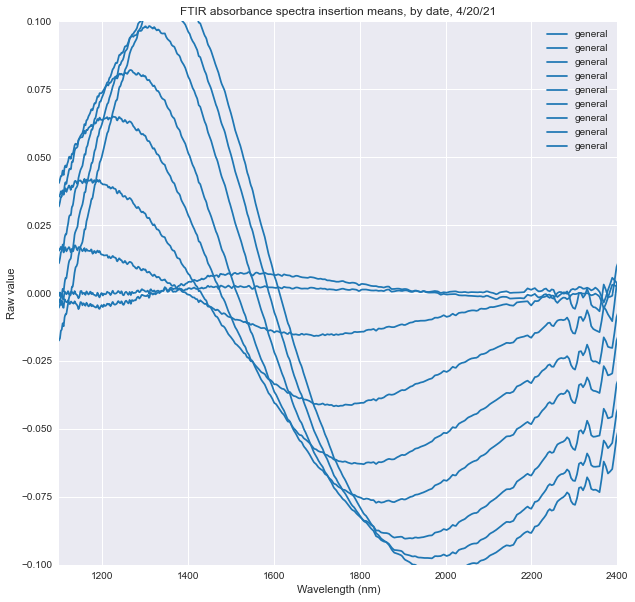

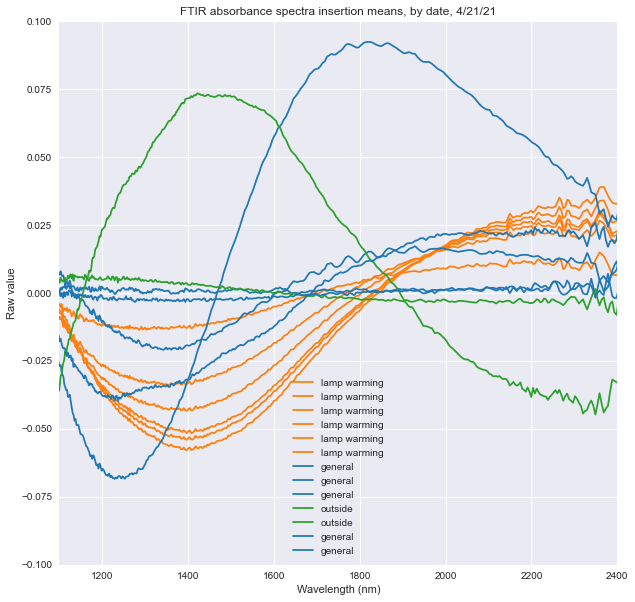

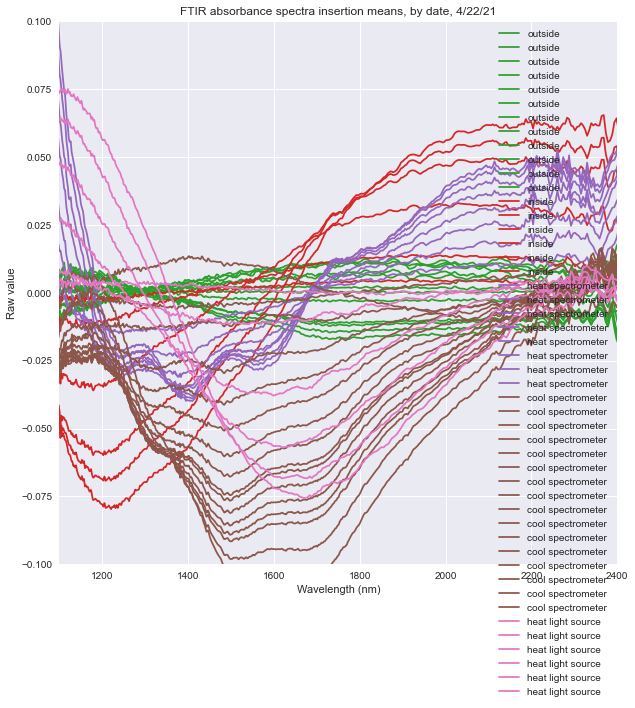

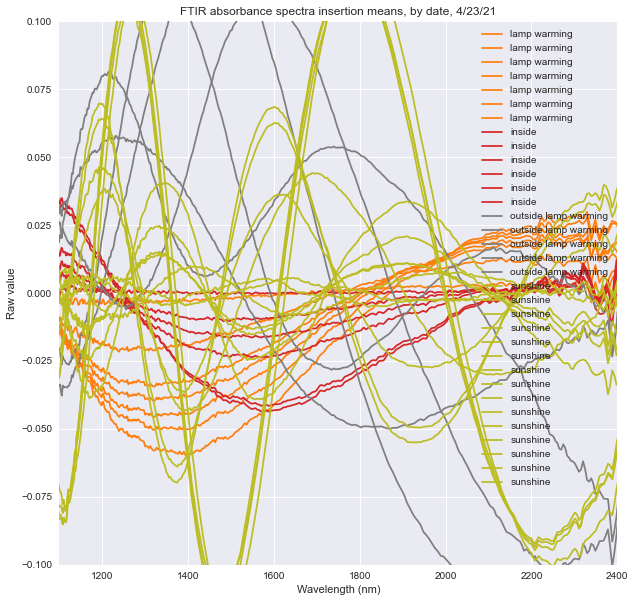

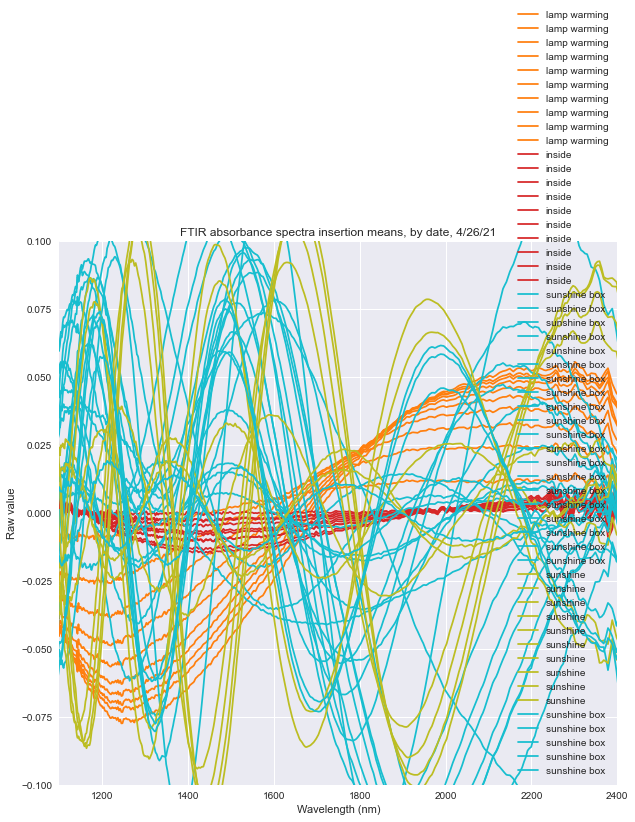

In [11]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
n = df['conditions'].unique().shape[0]
labels = df['conditions'].unique().tolist()
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.tab10.colors)
for date in df['date'].unique():
    small_df = df.loc[df['date'] == date].copy()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_ylabel("Raw value")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylim(-0.1, 0.1)
    ax.set_xlim(1100, 2400)
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]        
        insertion_temperature = get_insertion_temperature(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        calibration_spectrum = get_ftir_white_calibration_curve(file, calibration_path)
        ftir_abs_spectra = get_ftir_insertion_absorbances(file, insertion_path)
        date = small_df['date'][index]
        title = f"FTIR absorbance spectra insertion means, by date, {date}"
        condition = small_df['conditions'][index]
        label = labels[labels.index(condition)]
        color = "C" + str(labels.index(condition))
        
        ax.set_title(title)
        ax.plot(ftir_waves, ftir_abs_spectra.mean(axis=0), color=color, label=label)
    ax.legend()
    plt.show()
    plt.close()

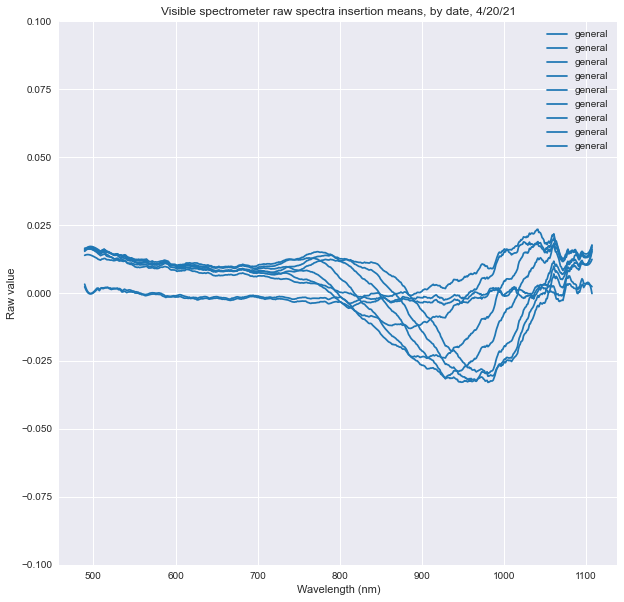

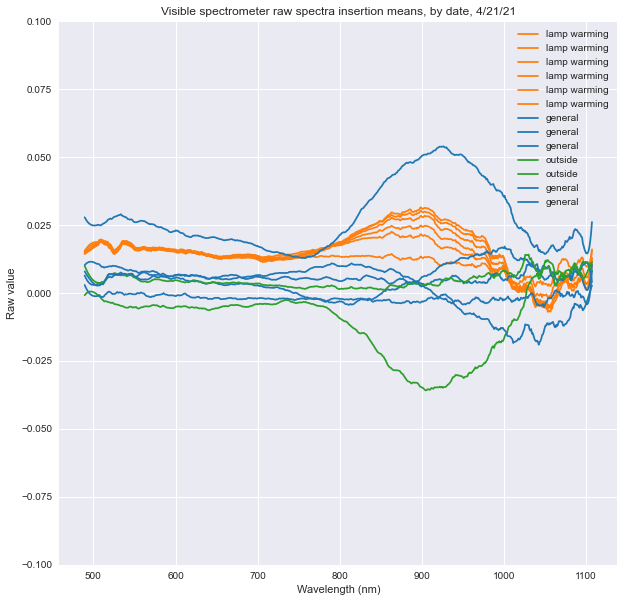

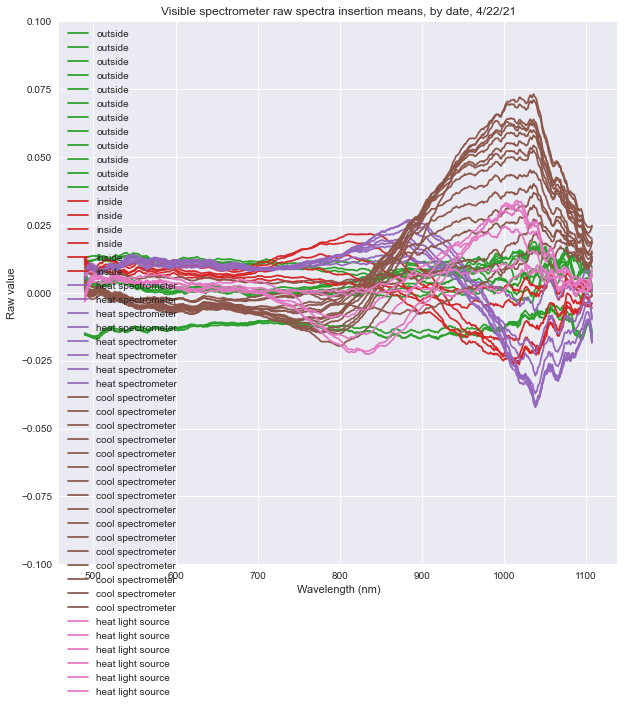

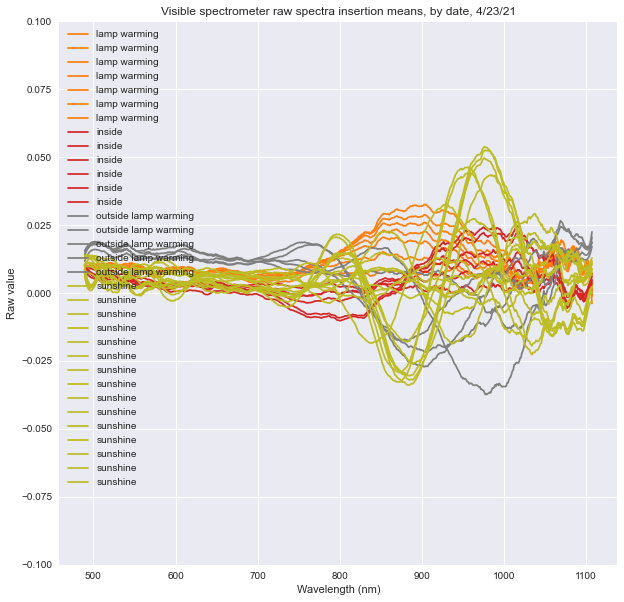

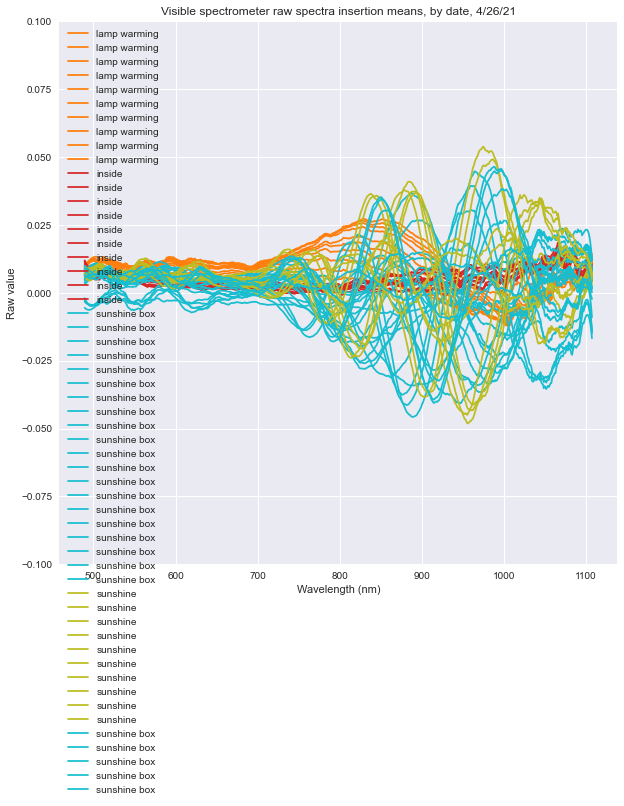

In [12]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
n = df['conditions'].unique().shape[0]
labels = df['conditions'].unique().tolist()
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.tab10.colors)
for date in df['date'].unique():
    small_df = df.loc[df['date'] == date].copy()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_ylabel("Raw value")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylim(-0.1, 0.1)
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]        
        insertion_temperature = get_insertion_temperature(file, insertion_path)
        vis_waves = get_visible_wavelength_vector(file, calibration_path)
        calibration_spectrum = get_visible_white_calibration_curve(file, calibration_path)
        vis_abs_spectra = get_visible_insertion_absorbances(file, insertion_path)
        date = small_df['date'][index]
        title = f"Visible spectrometer raw spectra insertion means, by date, {date}"
        condition = small_df['conditions'][index]
        label = labels[labels.index(condition)]
        color = "C" + str(labels.index(condition))
        
        ax.set_title(title)
        ax.plot(vis_waves, savgol_filter(vis_abs_spectra.mean(axis=0), 21, 3), color=color, label=label)
    ax.legend()
    plt.show()
    plt.close()

In [13]:
this_afternoon_df = df.loc[(df['date'] == '4/26/21') & (df['session'] == 'session002')].copy()

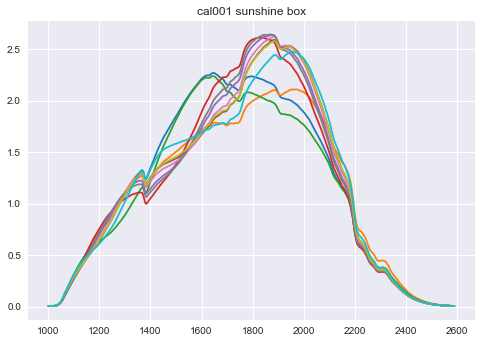

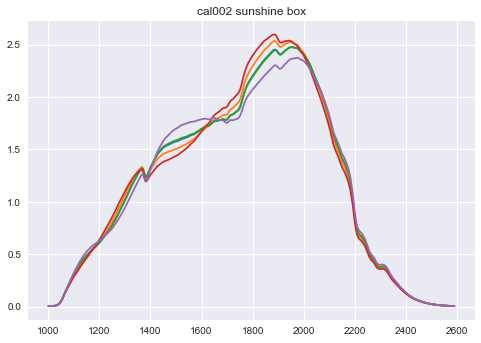

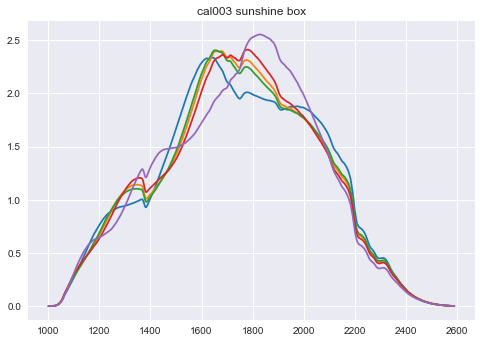

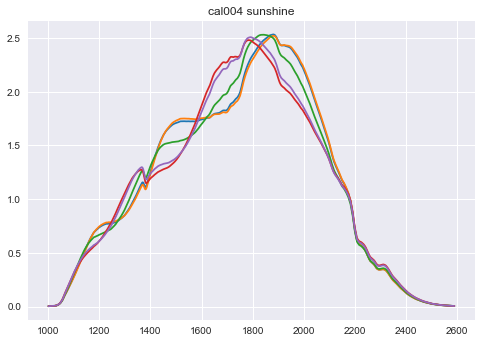

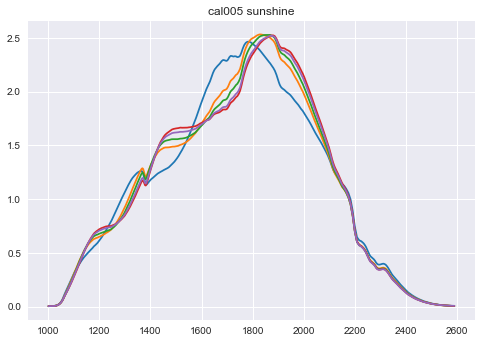

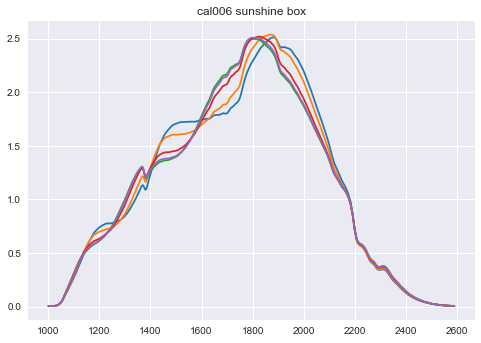

In [14]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_afternoon_df['calibration'].unique():
    small_df = this_afternoon_df.loc[this_afternoon_df['calibration'] == calibration].copy()
    fig, ax = plt.subplots()
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]        
        insertion_temperature = get_insertion_temperature(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        calibration_spectrum = get_ftir_white_calibration_curve(file, calibration_path)
        ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
        ax.set_title(small_df['calibration'][index] + " " + small_df['conditions'][index])

        ax.plot(ftir_waves, ftir_raw_spectra.mean(axis=0))
    plt.show()
    plt.close()
    
    

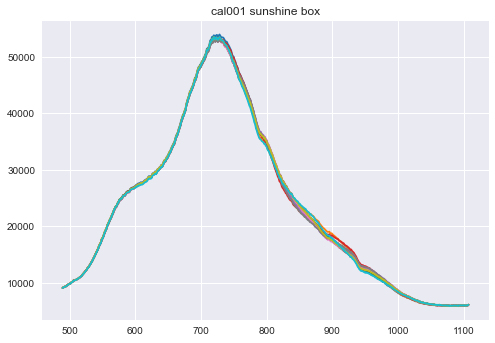

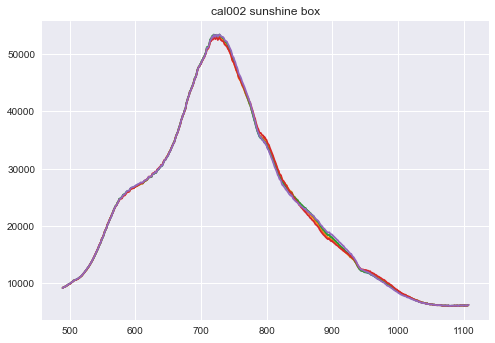

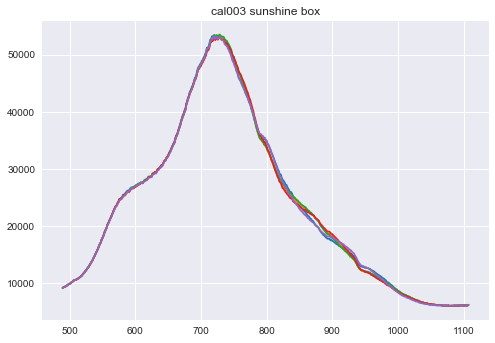

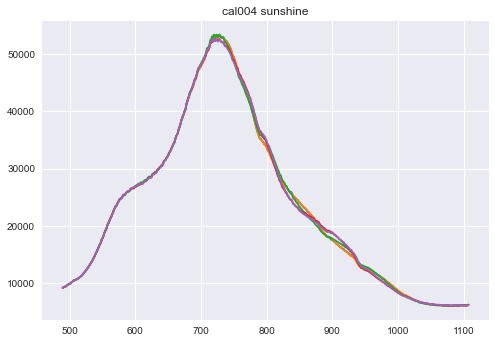

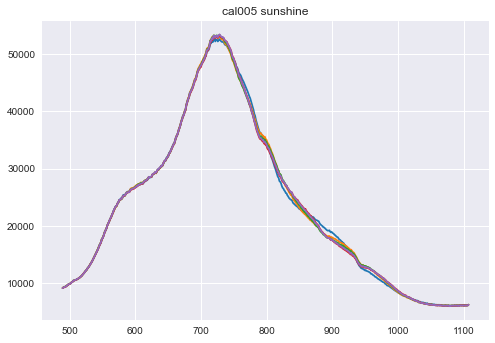

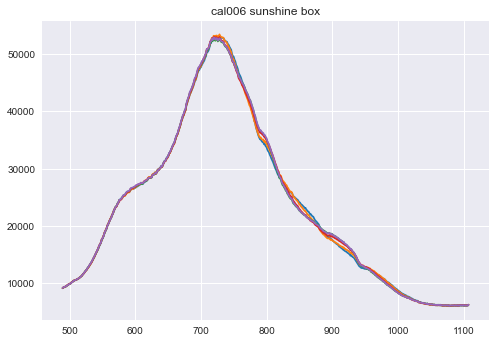

In [15]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_afternoon_df['calibration'].unique():
    small_df = this_afternoon_df.loc[this_afternoon_df['calibration'] == calibration].copy()
    fig, ax = plt.subplots()
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]        
        insertion_temperature = get_insertion_temperature(file, insertion_path)
        vis_waves = get_visible_wavelength_vector(file, calibration_path)
        calibration_spectrum = get_visible_white_calibration_curve(file, calibration_path)
        vis_raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)
        ax.set_title(small_df['calibration'][index] + " " + small_df['conditions'][index])

        ax.plot(vis_waves, vis_raw_spectra.mean(axis=0))
    plt.show()
    plt.close()

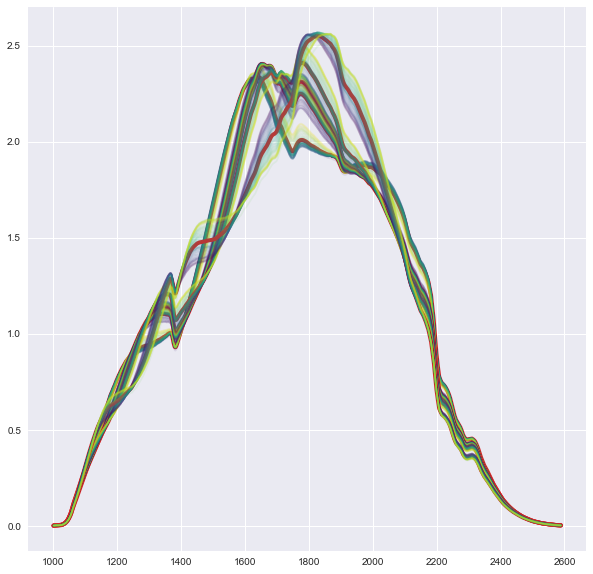

In [16]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in ['cal003']:
    small_df = this_afternoon_df.loc[this_afternoon_df['calibration'] == calibration].copy()
    fig, ax = plt.subplots(figsize=(10, 10))
    # ax.set_ylim(0.8, 1.0)
    # ax.set_xlim(2175, 2200)
    
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_temperature = get_insertion_temperature(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        calibration_spectrum = get_ftir_white_calibration_curve(file, calibration_path)
        ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
        
        ax.plot(ftir_waves, ftir_raw_spectra.mean(axis=0), 'tab:red', lw=4 )
        for i in range(ftir_raw_spectra.shape[0]):
            color = plt.cm.viridis(i/ftir_raw_spectra.shape[0])
            ax.plot(ftir_waves, ftir_raw_spectra[i, :], color=color, alpha=0.1)
            
        

        
    plt.show()
    plt.close()

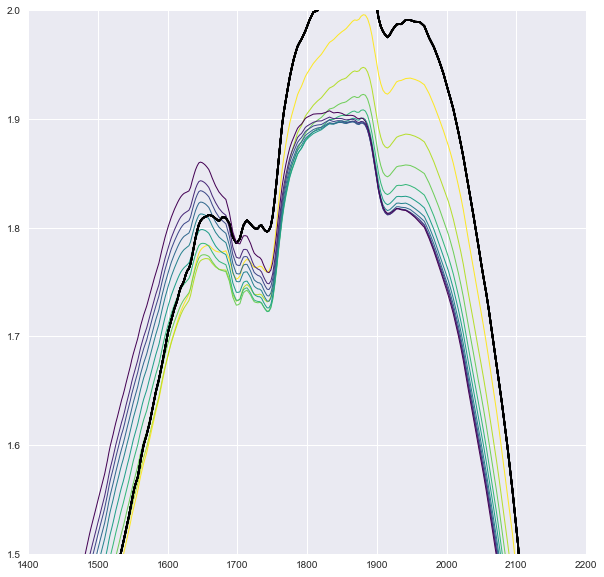

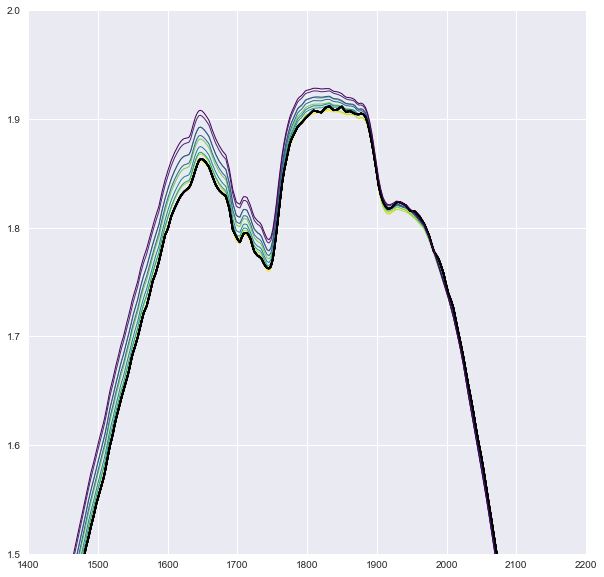

In [17]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

for calibration in this_morning_df['calibration'].unique():
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_ylim(1.5, 2.0)
    ax.set_xlim(1400, 2200)
    
    
    
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_temperature = get_insertion_temperature(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        calibration_spectrum = get_ftir_white_calibration_curve(file, calibration_path)
        ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
        color = plt.cm.viridis((small_df.index[-1] - index) /(small_df.index[-1] - small_df.index[0]))
        ax.plot(ftir_waves, calibration_spectrum, 'k')
        
        ax.plot(ftir_waves, ftir_raw_spectra.mean(axis=0), color=color, lw=1 )
        for i in range(ftir_raw_spectra.shape[0]):
            color = plt.cm.viridis(i/ftir_raw_spectra.shape[0])
            # ax.plot(ftir_waves, ftir_raw_spectra[i, :], color=color, alpha=0.1)
            
        

        
    plt.show()
    plt.close()

# Plot Maximum absorbance value for FTIR spectra, 4/26/21 morning spectra

For each spectrum acquired, plot the absolute value of the the maximum absorbance value of the spectrum by the time elapsed since the first spectrum in the insertion.  Each insertion is graphed separately.

In the first insertions shown, the light source was warming up, since data collection started immediately after turning on the light source.  Thus the maximum absorbance increases quite rapidly, both during an insertion, and from one insertion to another.  The rate of increase begins to level out by around insertion ins005, though it continues to increase slowly until the spectrometer is recalibrated after ins010.

Absorbance values remain low from ins011 until the end of the sequence of insertions.

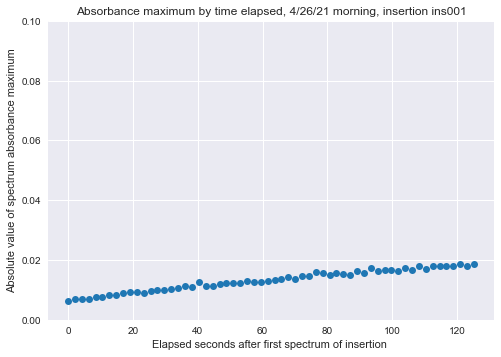

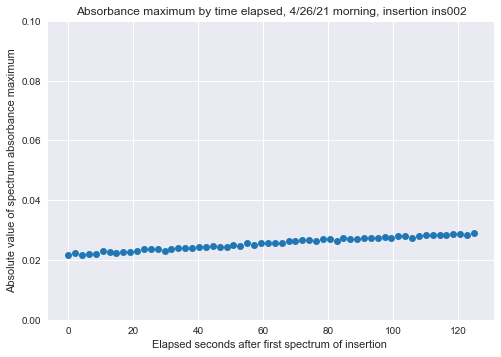

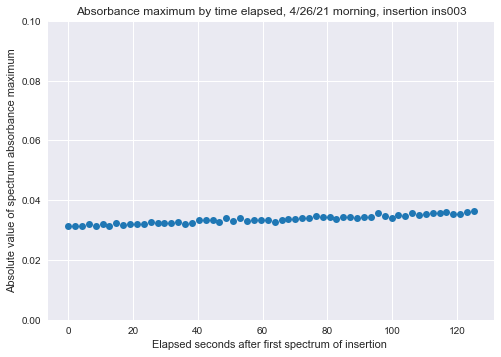

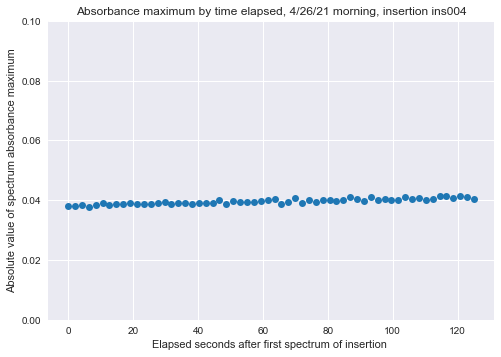

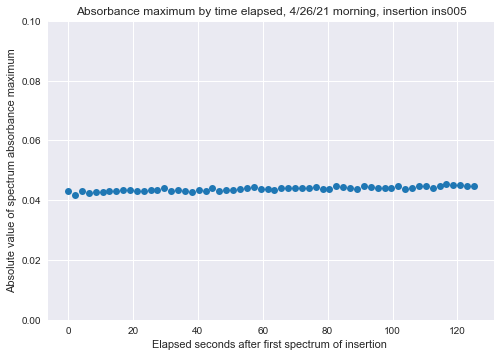

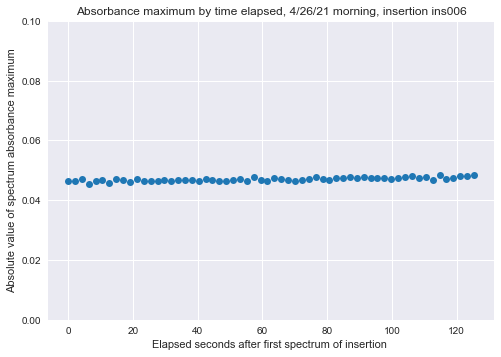

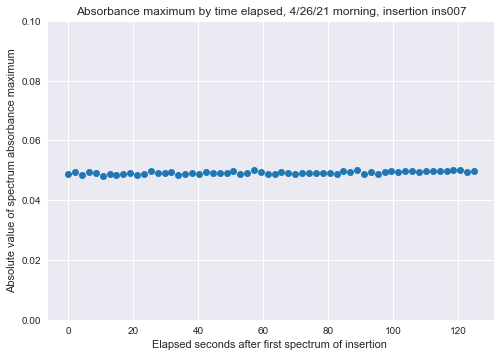

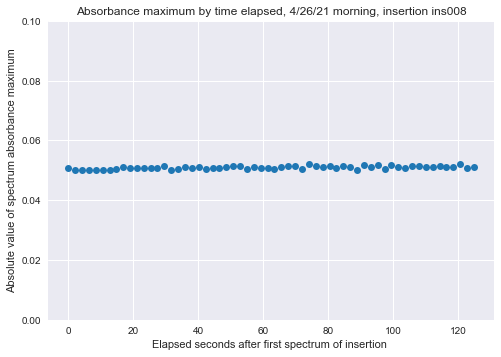

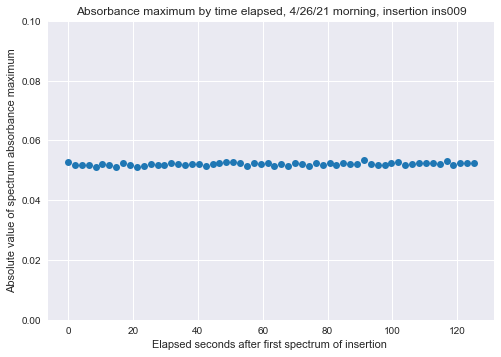

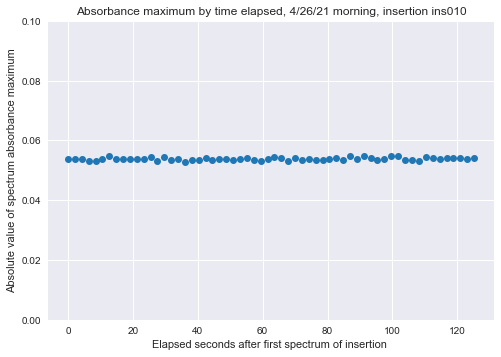

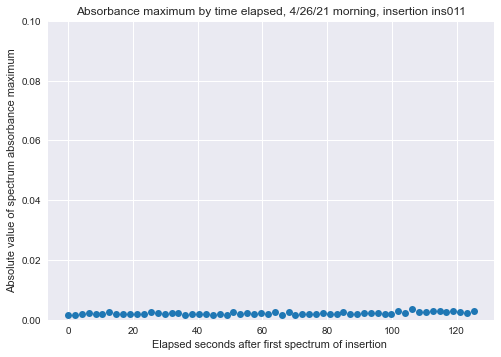

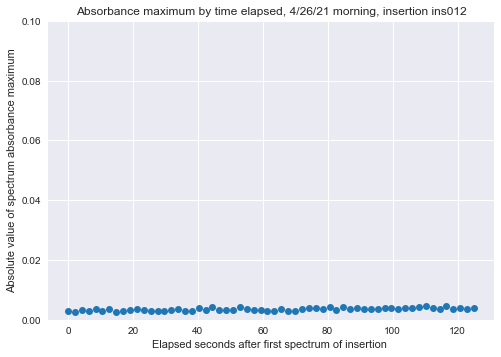

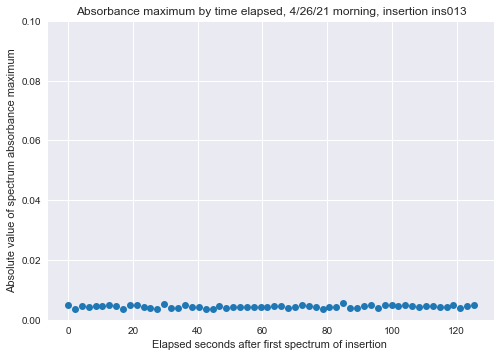

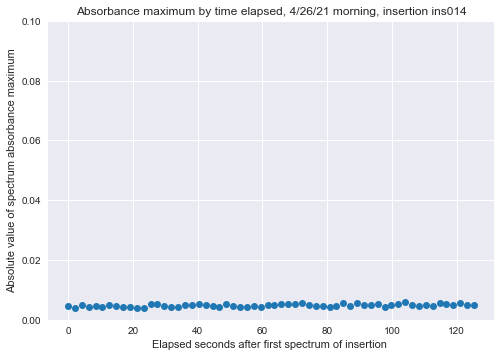

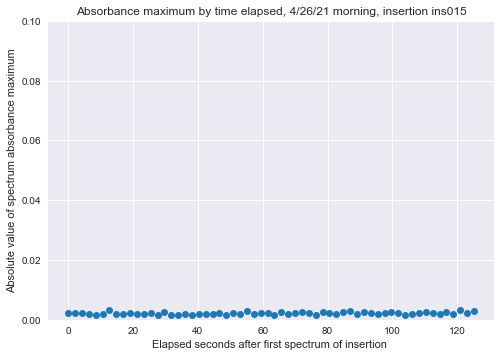

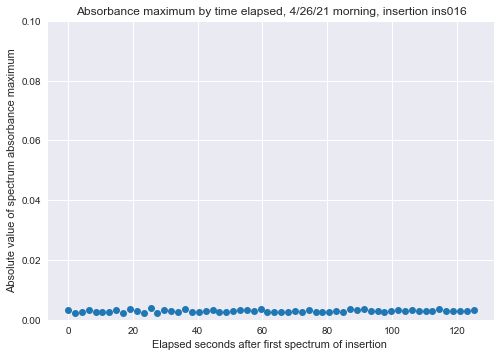

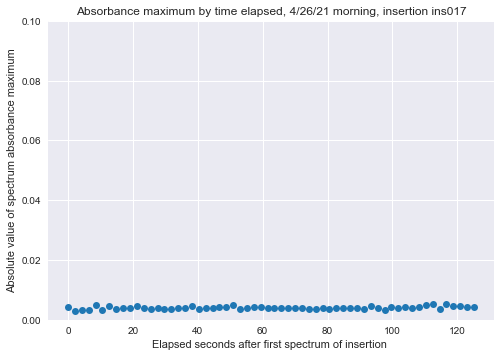

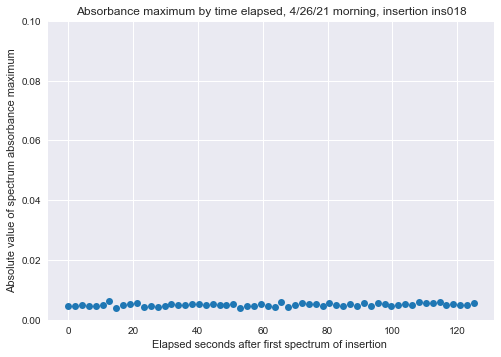

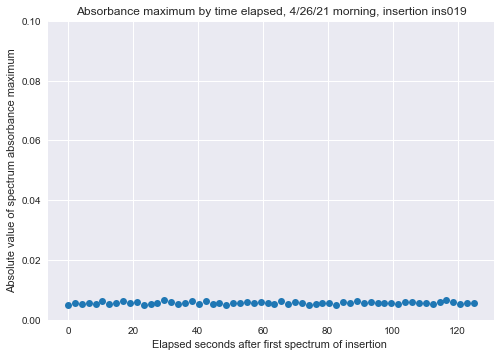

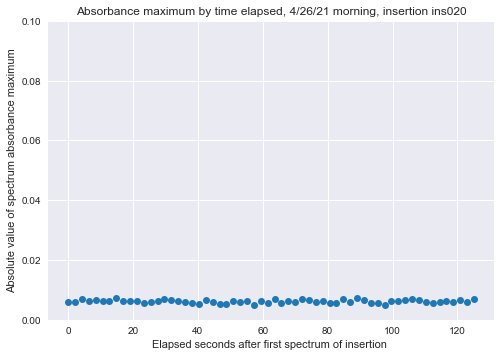

In [18]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(ftir_waves, 1200)
        end_index = find_position_in_wavelength_vector(ftir_waves, 2200)
        ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
        ftir_white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
        ftir_dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        fig, ax = plt.subplots()
        first_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, 0)
        insertion_df = pd.DataFrame()
        for i in range(ftir_raw_spectra.shape[0]):
            absorbance_spectrum = calculate_absorbance_from_raw(ftir_raw_spectra[i, start_index:end_index], ftir_white_spectrum, ftir_dark_spectrum)
            max_absorbance = abs(absorbance_spectrum.max())
            spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            
        ax.plot(insertion_df["time_delta"], insertion_df["max_absorbance"], 'o')
        ax.set_title(f'Absorbance maximum by time elapsed, 4/26/21 morning, insertion {insertion}')
        ax.set_ylabel('Absolute value of spectrum absorbance maximum')
        ax.set_xlabel('Elapsed seconds after first spectrum of insertion ')
        
        ax.set_ylim(0, 0.1)
        plt.show()
        plt.close()
        

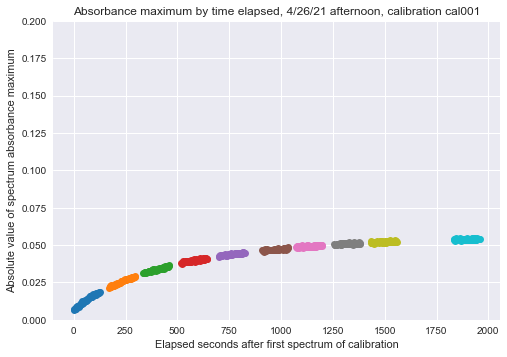

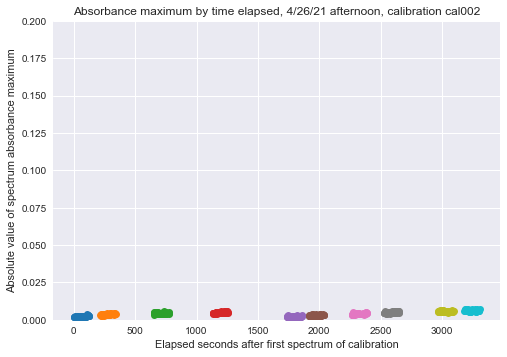

In [29]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    fig, ax = plt.subplots()
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
    calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
    calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
    
    first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
    for index in small_df.index:  
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(ftir_waves, 1200)
        end_index = find_position_in_wavelength_vector(ftir_waves, 2200)
        ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
        ftir_white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
        ftir_dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        
        
        insertion_df = pd.DataFrame()
        for i in range(ftir_raw_spectra.shape[0]):
            absorbance_spectrum = calculate_absorbance_from_raw(ftir_raw_spectra[i, start_index:end_index], ftir_white_spectrum, ftir_dark_spectrum)
            max_absorbance = abs(absorbance_spectrum.max())
            spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            
        ax.plot(insertion_df["time_delta"], insertion_df["max_absorbance"], 'o')
    ax.set_title(f'Absorbance maximum by time elapsed, 4/26/21 afternoon, calibration {calibration}')
    ax.set_ylabel('Absolute value of spectrum absorbance maximum')
    ax.set_xlabel('Elapsed seconds after first spectrum of calibration')

    ax.set_ylim(0, 0.2)
    plt.show()
    plt.close()

# Plot absorbance spectra for FTIR engine, 4/26/21 morning spectra

The individual absorbance spectra are plotted with color varying by order of acquisition, with the mean spectrum of the insertion shown in black.

In the first insertions shown, the light source was warming up, since data collection started immediately after turning on the light source.  Thus the maximum absorbance increases quite rapidly, both during an insertion, and from one insertion to another.  The rate of increase begins to level out by around insertion ins005, though it continues to increase slowly until the spectrometer is recalibrated after ins010.

Absorbance values remain low from ins011 until the end of the sequence of insertions.

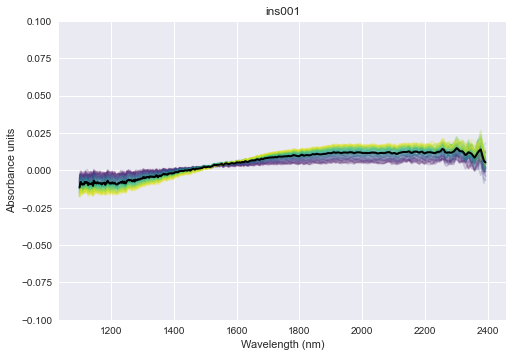

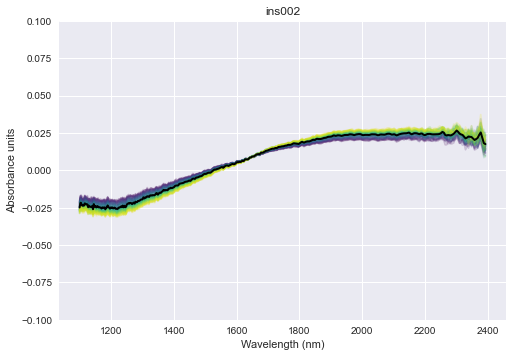

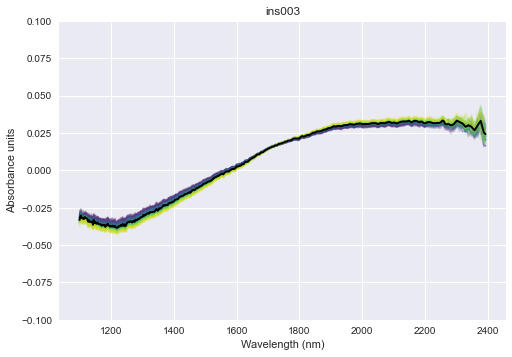

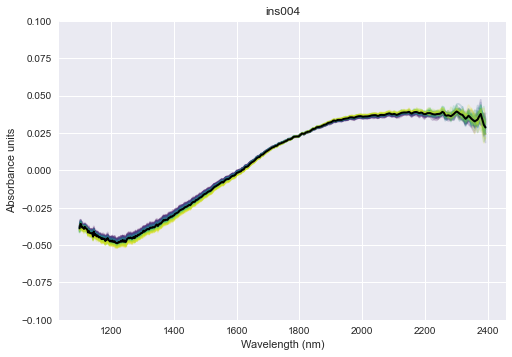

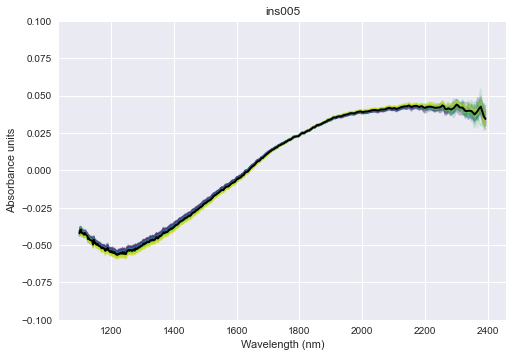

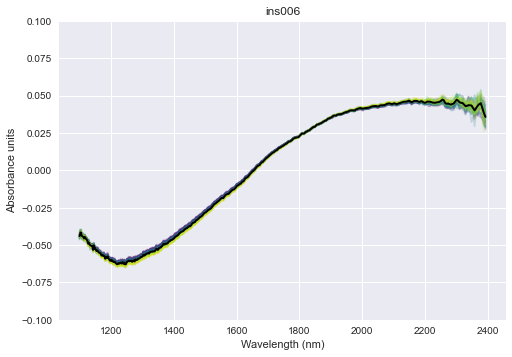

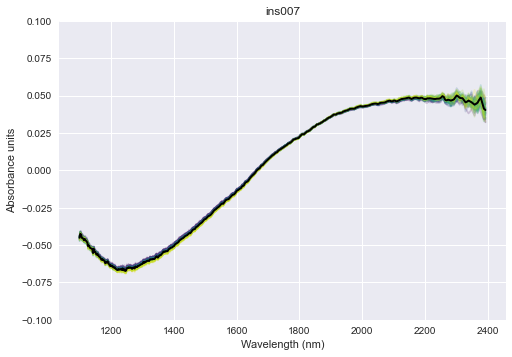

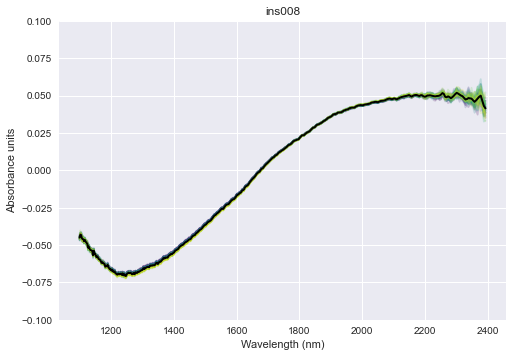

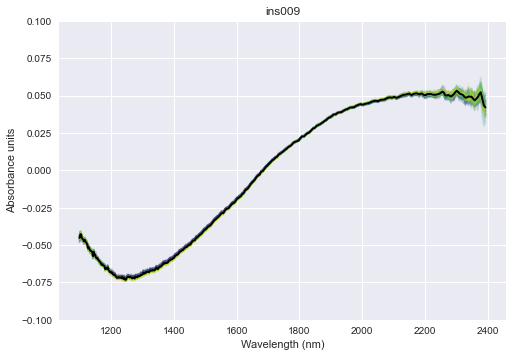

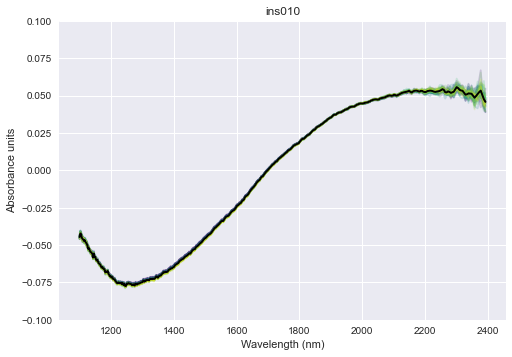

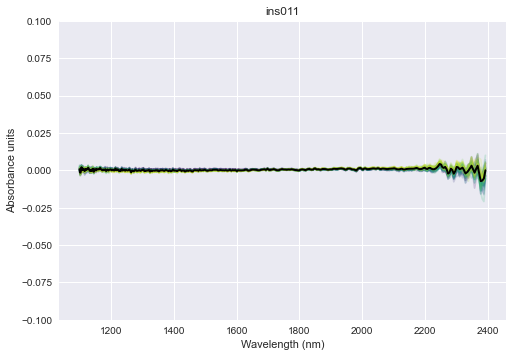

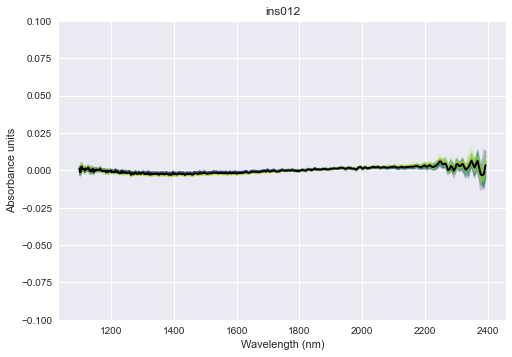

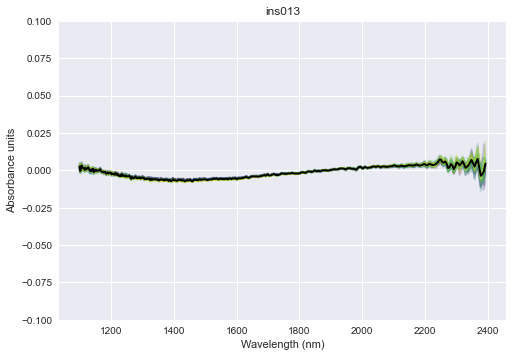

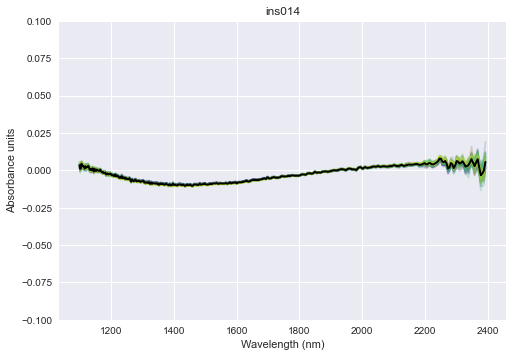

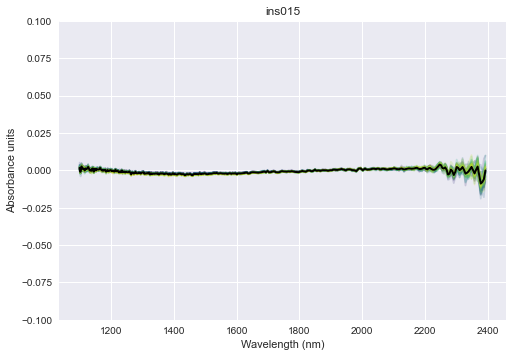

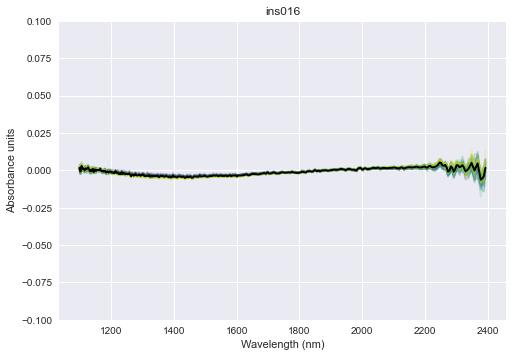

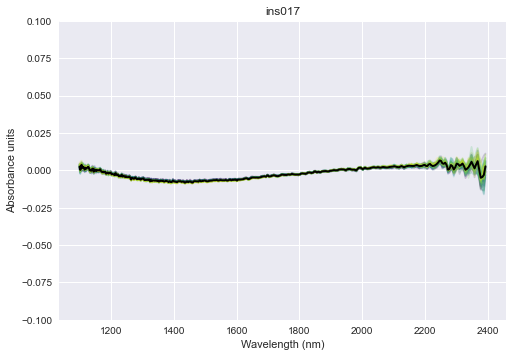

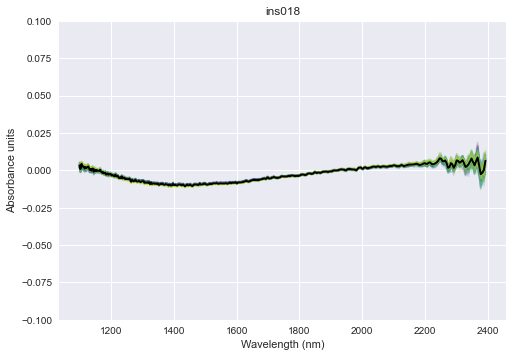

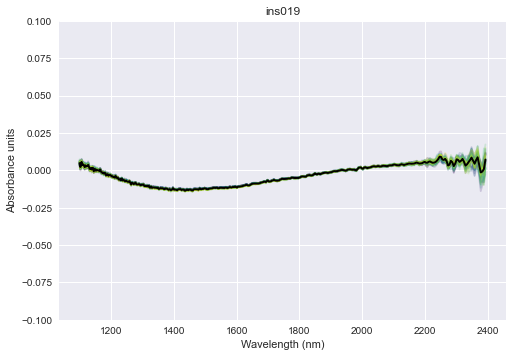

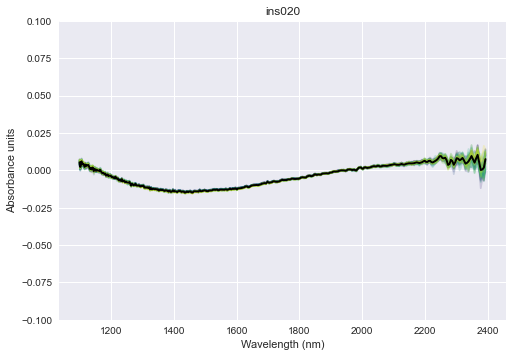

In [30]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(ftir_waves, 1100)
        end_index = find_position_in_wavelength_vector(ftir_waves, 2400)
        ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
        absorbance_spectra = np.empty_like(ftir_raw_spectra[:, start_index:end_index], dtype=np.double)
        ftir_white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
        ftir_dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        fig, ax = plt.subplots()
        first_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, 0)
        insertion_df = pd.DataFrame()
        for i in range(ftir_raw_spectra.shape[0]):
            absorbance_spectrum = calculate_absorbance_from_raw(ftir_raw_spectra[i, start_index:end_index], ftir_white_spectrum, ftir_dark_spectrum)
            max_absorbance = abs(absorbance_spectrum.max())
            spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            color = plt.cm.viridis(normalize(i, ftir_raw_spectra.shape[0], 0))
            absorbance_spectra[i, :] = absorbance_spectrum
            
            ax.plot(ftir_waves[start_index:end_index], absorbance_spectrum, color=color, alpha=0.2)
        ax.plot(ftir_waves[start_index:end_index], absorbance_spectra.mean(axis=0), 'k', lw=2)
        ax.set_title(insertion)
        ax.set_ylabel("Absorbance units")
        ax.set_xlabel("Wavelength (nm)")
        ax.set_ylim(-0.1, 0.1)
        plt.show()
        plt.close()

# Plot wavelength of maximum absorbance, FTIR engine, 4/26/21 morning spectra

The wavelength of the maximum value of the absolute value of the absorbance spectrum are plotted by the time elapsed since the first spectrum of the the insertion.

If there is no wavelength dependence, the wavelength of the maximum absorbance would be expected to lie at the ends of the spectrum acquired because that is where there is higher noise.

In the first insertions shown, the light source was warming up, since data collection started immediately after turning on the light source.  Gradually the wavelength moves away from the edges of the spectrum towards a peak between 1400 and 1500 nm.

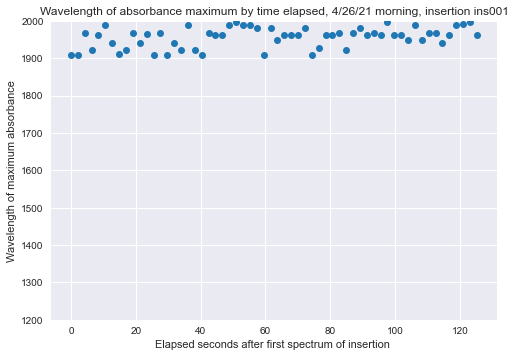

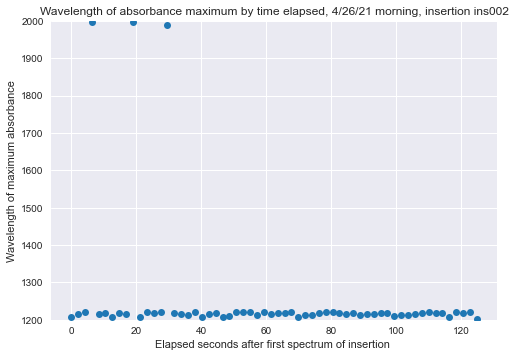

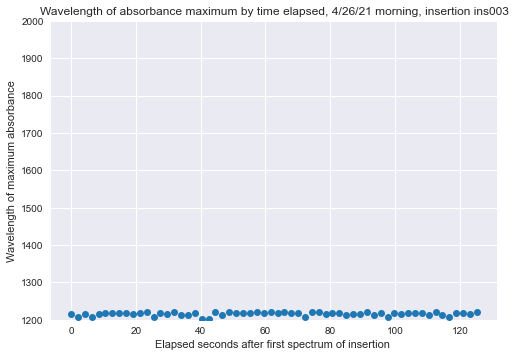

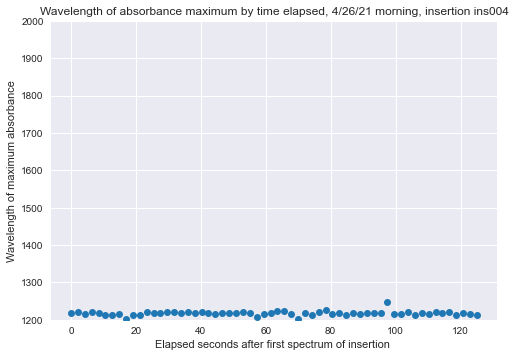

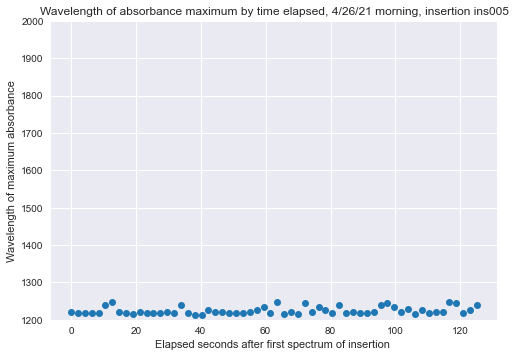

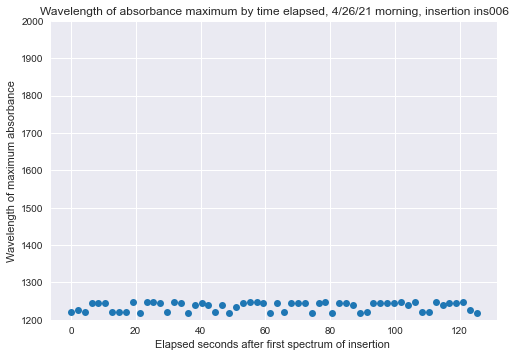

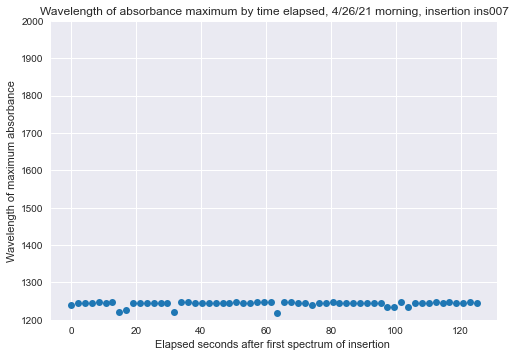

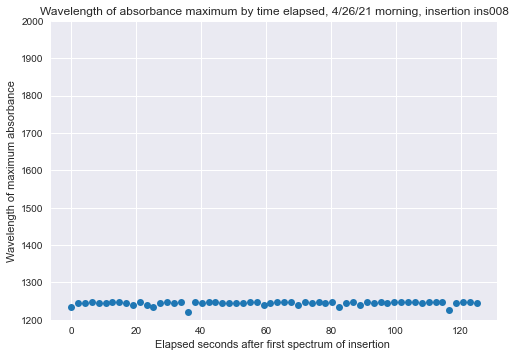

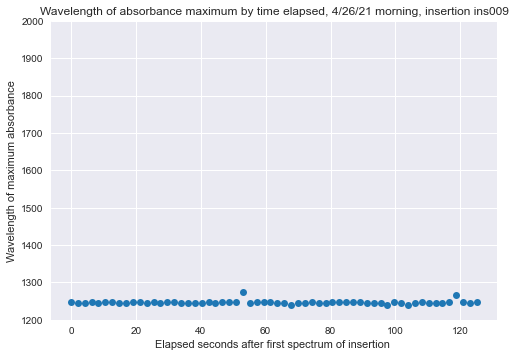

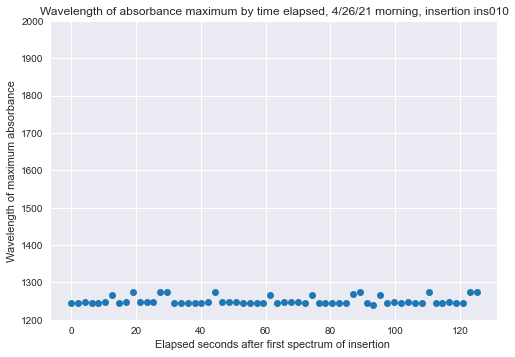

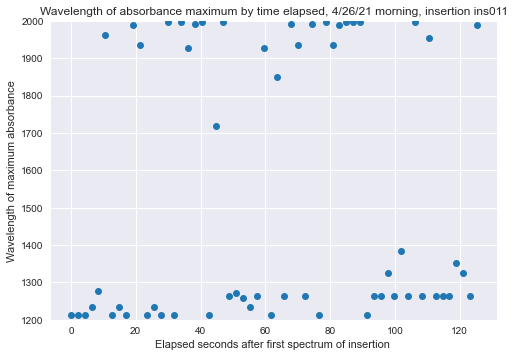

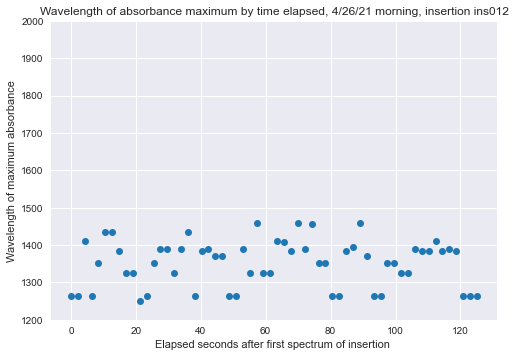

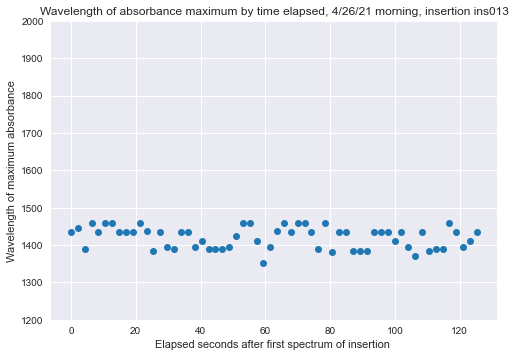

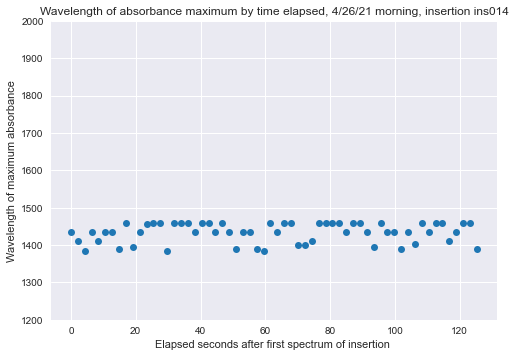

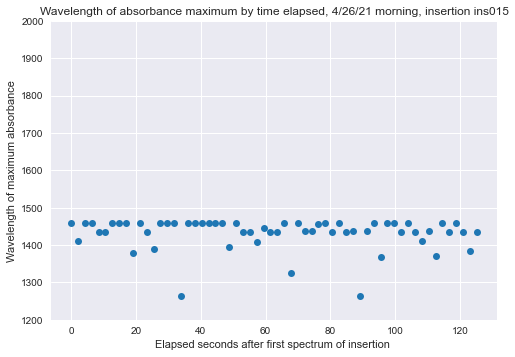

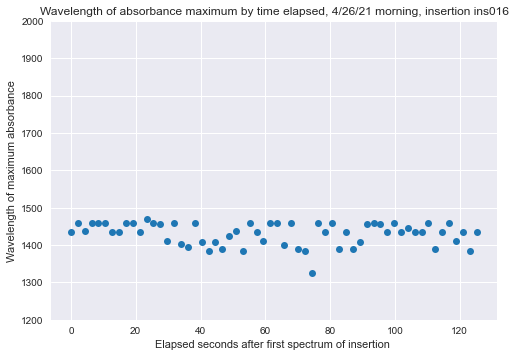

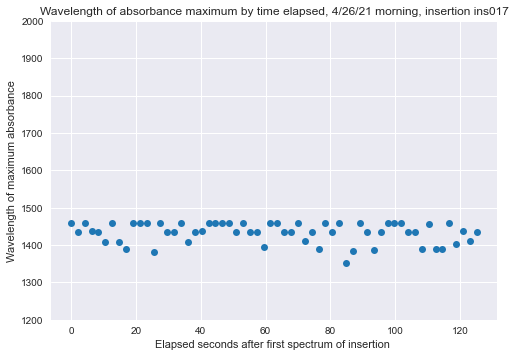

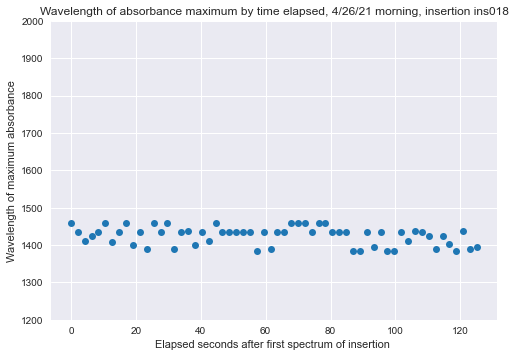

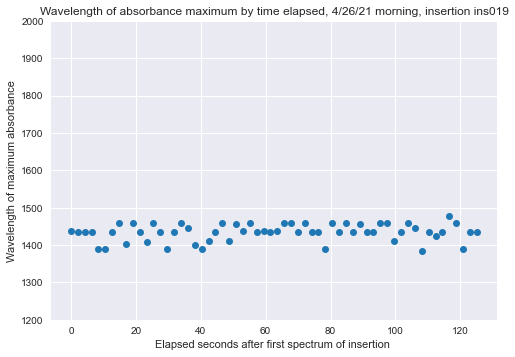

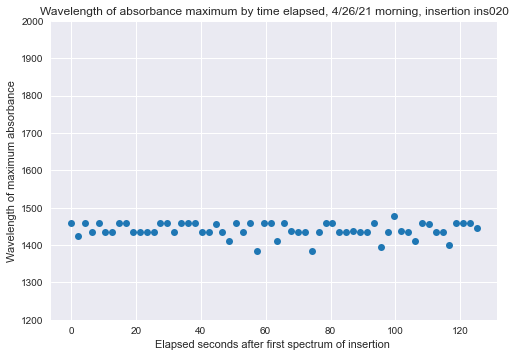

In [31]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(ftir_waves, 1200)
        end_index = find_position_in_wavelength_vector(ftir_waves, 2000)
        ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
        ftir_white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
        ftir_dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        fig, ax = plt.subplots()
        first_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, 0)
        insertion_df = pd.DataFrame()
        for i in range(ftir_raw_spectra.shape[0]):
            absorbance_spectrum = calculate_absorbance_from_raw(ftir_raw_spectra[i, start_index:end_index], ftir_white_spectrum, ftir_dark_spectrum)
            max_absorbance = abs(absorbance_spectrum).max()
            try:
                max_absorbance_position = np.where(np.isclose(abs(absorbance_spectrum), max_absorbance))[0][0]
            except:
                max_absorbance_position = np.where(np.isclose(absorbance_spectrum, -max_absorbance))[0][0]
            wavelength_max = ftir_waves[start_index:end_index][max_absorbance_position]            
            spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            insertion_df.loc[i, "wavelength_max"] = wavelength_max
            
        ax.plot(insertion_df["time_delta"], insertion_df["wavelength_max"], 'o')
        ax.set_title(f'Wavelength of absorbance maximum by time elapsed, 4/26/21 morning, insertion {insertion}')
        ax.set_ylabel('Wavelength of maximum absorbance')
        ax.set_xlabel('Elapsed seconds after first spectrum of insertion ')
        ax.set_ylim(1200, 2000)
        plt.show()
        plt.close()

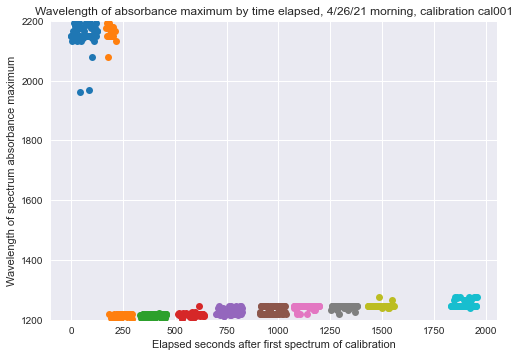

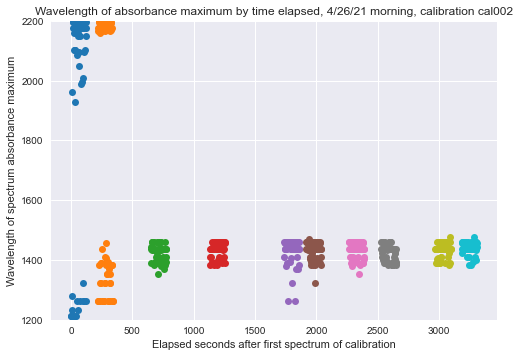

In [32]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    fig, ax = plt.subplots()
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
    calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
    calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
    
    first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
    for index in small_df.index:  
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(ftir_waves, 1200)
        end_index = find_position_in_wavelength_vector(ftir_waves, 2200)
        ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
        ftir_white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
        ftir_dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        
        
        insertion_df = pd.DataFrame()
        for i in range(ftir_raw_spectra.shape[0]):
            absorbance_spectrum = calculate_absorbance_from_raw(ftir_raw_spectra[i, start_index:end_index], ftir_white_spectrum, ftir_dark_spectrum)
            max_absorbance = abs(absorbance_spectrum).max()
            try:
                max_absorbance_position = np.where(np.isclose(abs(absorbance_spectrum), max_absorbance))[0][0]
            except:
                max_absorbance_position = np.where(np.isclose(absorbance_spectrum, -max_absorbance))[0][0]
            wavelength_max = ftir_waves[start_index:end_index][max_absorbance_position]
            spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            insertion_df.loc[i, "wavelength_max"] = wavelength_max
            
        ax.plot(insertion_df["time_delta"], insertion_df["wavelength_max"], 'o')
    ax.set_title(f'Wavelength of absorbance maximum by time elapsed, 4/26/21 morning, calibration {calibration}')
    ax.set_ylabel('Wavelength of spectrum absorbance maximum')
    ax.set_xlabel('Elapsed seconds after first spectrum of calibration')

    ax.set_ylim(1200, 2200)
    plt.show()
    plt.close()

# Plot Maximum absorbance value for visible spectra, 4/26/21 morning spectra

For each spectrum acquired, plot the absolute value of the the maximum absorbance value of the spectrum by the time elapsed since the first spectrum in the insertion. Each insertion is graphed separately.

The visible spectrometer spectra are noisier than the FTIR engine spectra, so have somewhat higher absorbance values when the spectra are stable.  (The spectra were filtered to smooth them out before determining the maximum absorbance value.)

In the first insertions shown, the light source was warming up, since data collection started immediately after turning on the light source. Thus the maximum absorbance increases steadily from one insertion to another until the spectrometer is recalibrated after ins010.

Absorbance values again increase steadily from ins011 until the end of the sequence of insertions.

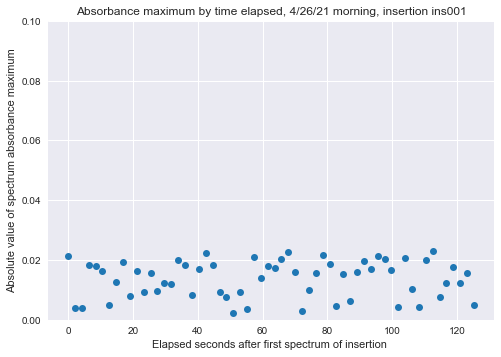

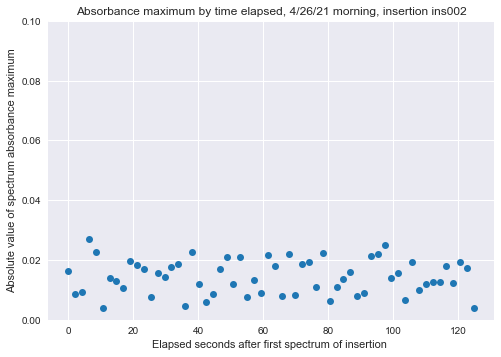

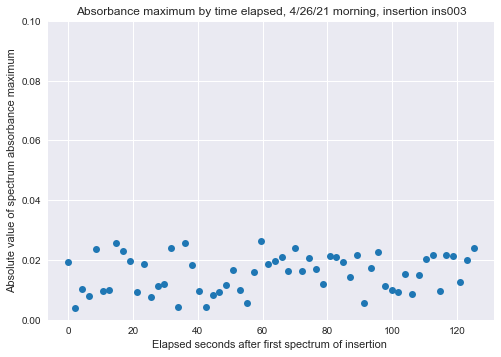

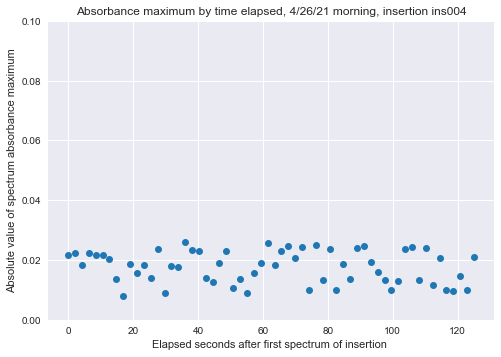

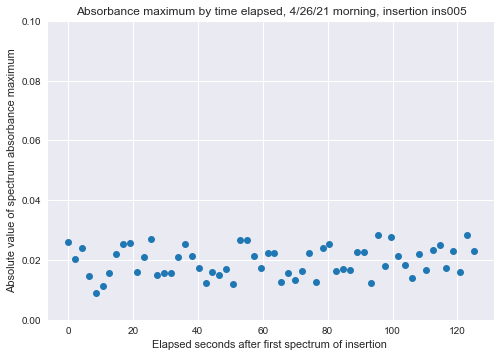

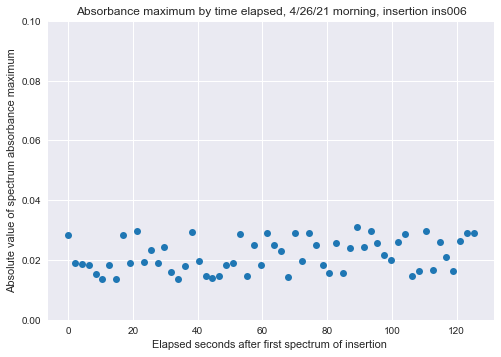

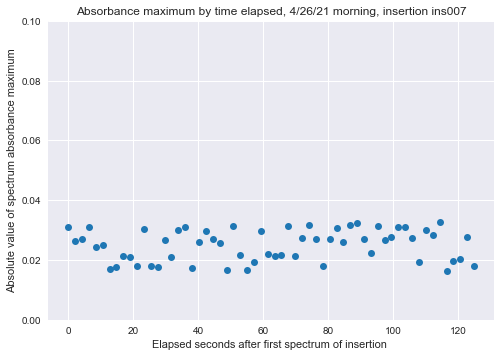

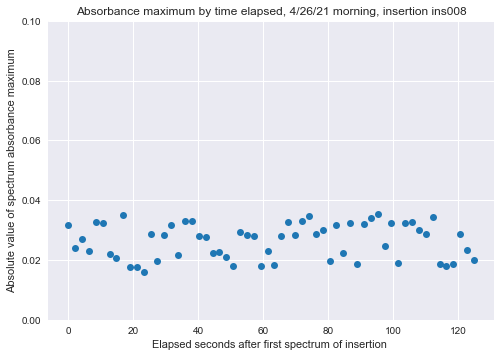

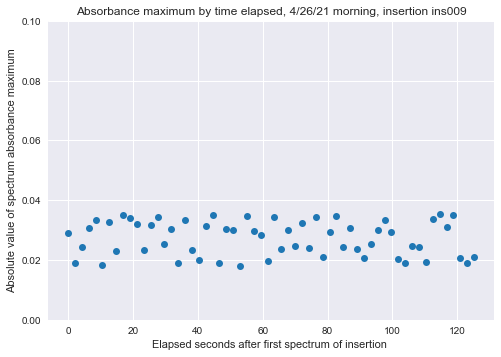

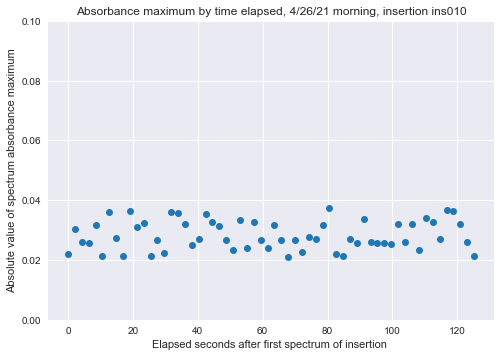

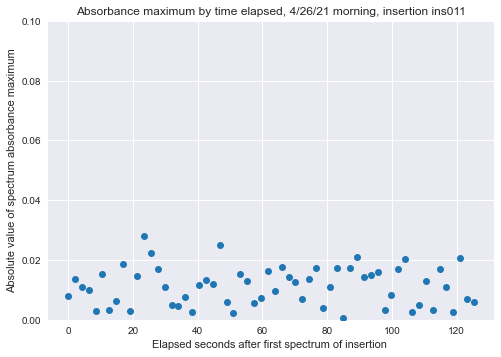

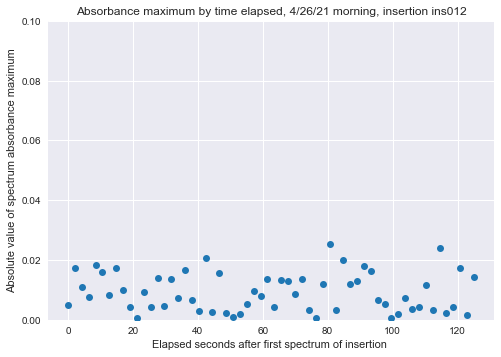

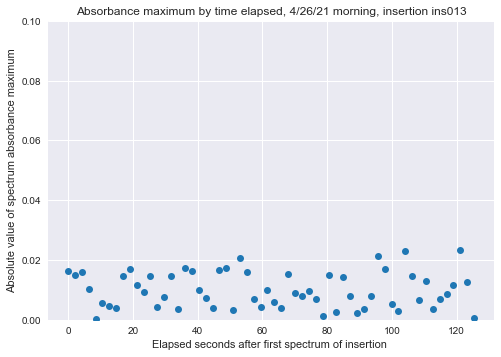

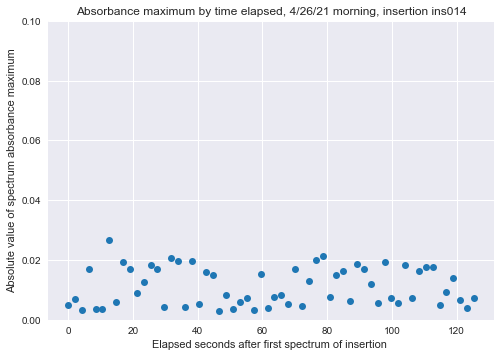

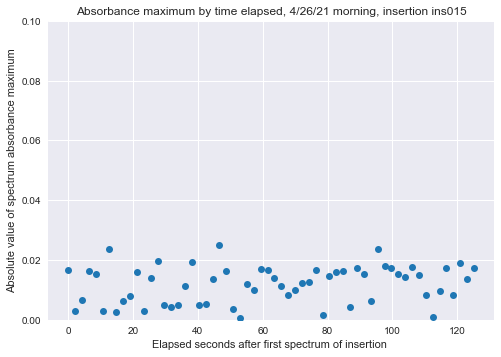

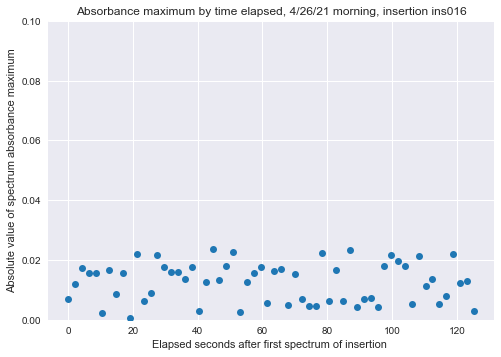

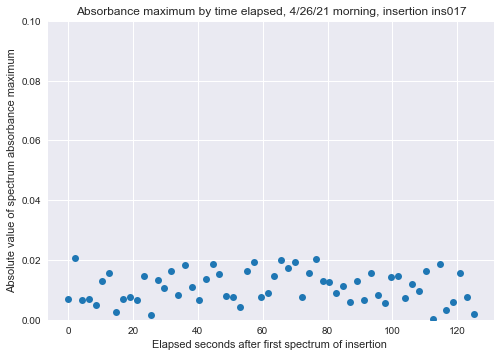

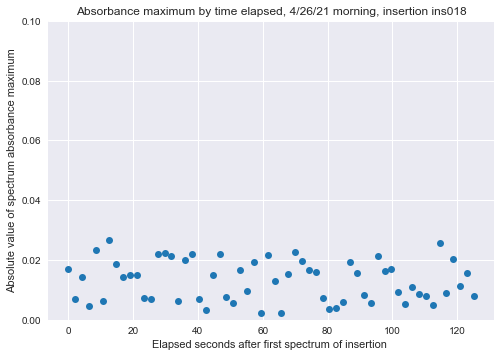

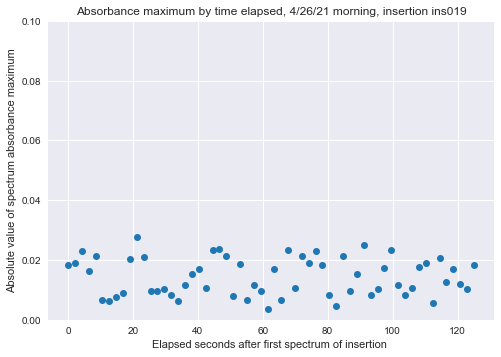

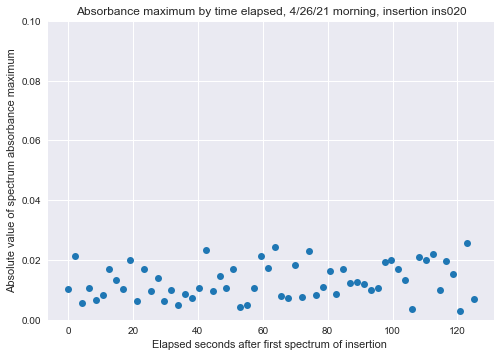

In [26]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        vis_waves = get_visible_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(vis_waves, 500)
        end_index = find_position_in_wavelength_vector(vis_waves, 1000)
        vis_raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)
        vis_white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
        vis_dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        fig, ax = plt.subplots()
        first_timestamp = get_visible_spectrum_timestamp(file, insertion_path, 0)
        insertion_df = pd.DataFrame()
        for i in range(vis_raw_spectra.shape[0]):
            absorbance_spectrum = savgol_filter(calculate_absorbance_from_raw(vis_raw_spectra[i, start_index:end_index], vis_white_spectrum, vis_dark_spectrum), 21, 3)
            max_absorbance = abs(absorbance_spectrum.max())
            spectrum_timestamp = get_visible_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            
        ax.plot(insertion_df["time_delta"], insertion_df["max_absorbance"], 'o')
        ax.set_title(f'Absorbance maximum by time elapsed, 4/26/21 morning, insertion {insertion}')
        ax.set_ylabel('Absolute value of spectrum absorbance maximum')
        ax.set_xlabel('Elapsed seconds after first spectrum of insertion ')
        ax.set_ylim(0, 0.1)
        plt.show()
        plt.close()

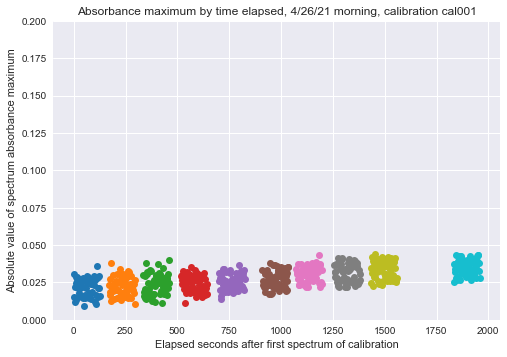

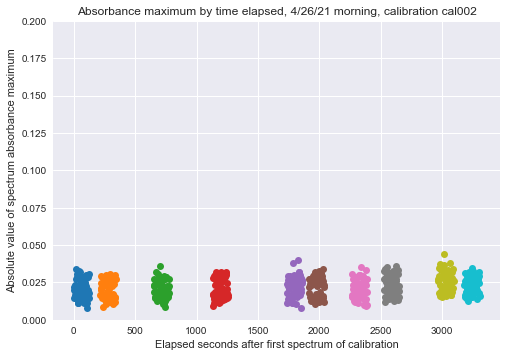

In [33]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    fig, ax = plt.subplots()
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
    calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
    calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
    
    first_timestamp = get_visible_spectrum_timestamp(file, calibration_insertions[0], 0)
    for index in small_df.index:  
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        vis_waves = get_visible_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(vis_waves, 500)
        end_index = find_position_in_wavelength_vector(vis_waves, 1000)
        vis_raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)
        vis_white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
        vis_dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        
        
        insertion_df = pd.DataFrame()
        for i in range(vis_raw_spectra.shape[0]):
            absorbance_spectrum = calculate_absorbance_from_raw(vis_raw_spectra[i, start_index:end_index], vis_white_spectrum, vis_dark_spectrum)
            max_absorbance = abs(absorbance_spectrum.max())
            spectrum_timestamp = get_visible_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            
        ax.plot(insertion_df["time_delta"], insertion_df["max_absorbance"], 'o')
    ax.set_title(f'Absorbance maximum by time elapsed, 4/26/21 morning, calibration {calibration}')
    ax.set_ylabel('Absolute value of spectrum absorbance maximum')
    ax.set_xlabel('Elapsed seconds after first spectrum of calibration')

    ax.set_ylim(0, 0.2)
    plt.show()
    plt.close()

# Plot absorbance spectra for visible spectrometer, 4/26/21 morning spectra

The individual absorbance spectra are plotted with color varying by order of acquisition, with the mean spectrum of the insertion shown in black.

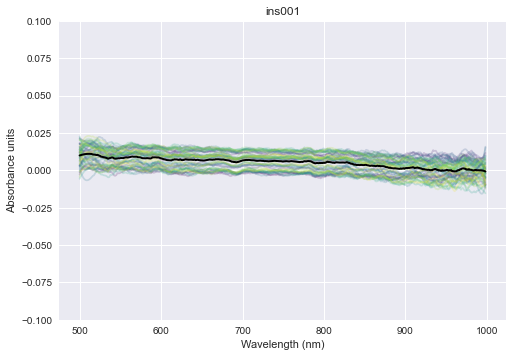

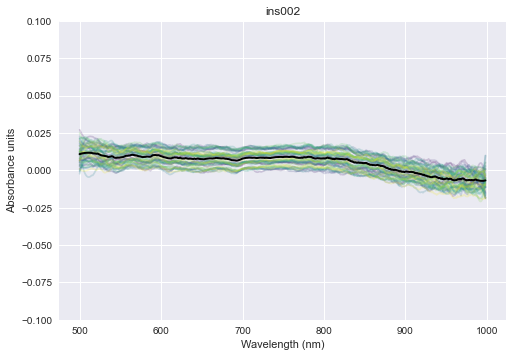

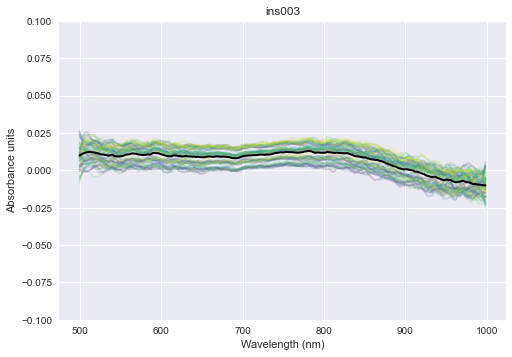

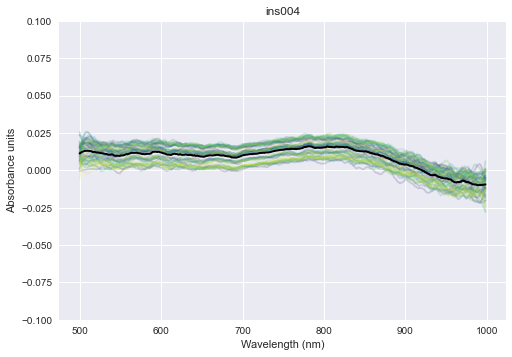

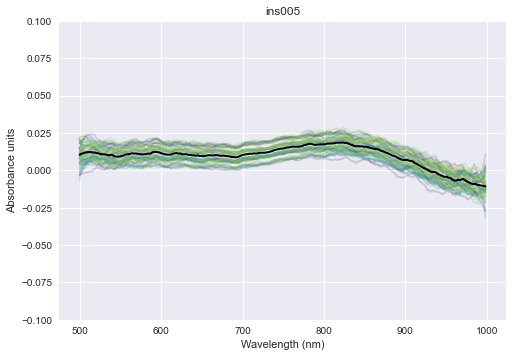

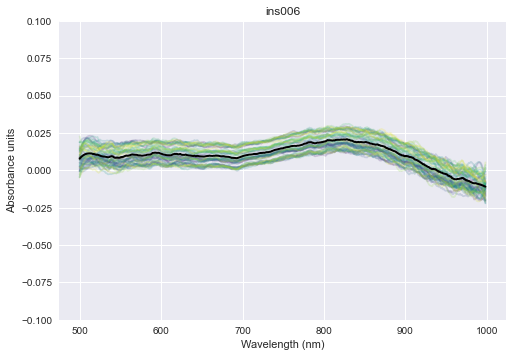

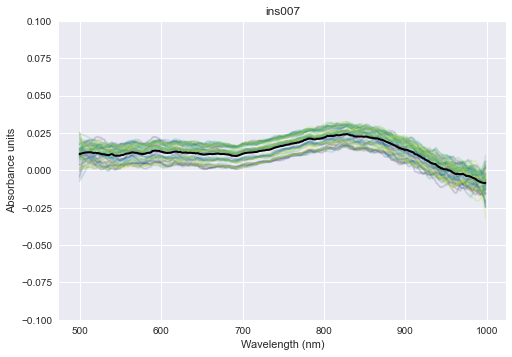

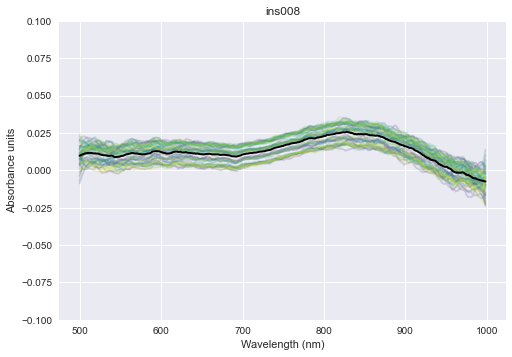

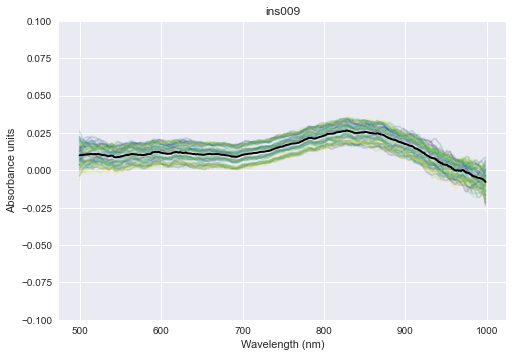

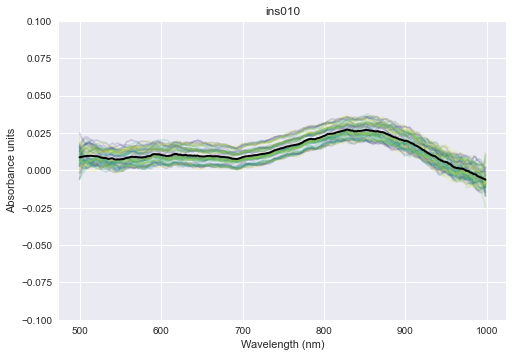

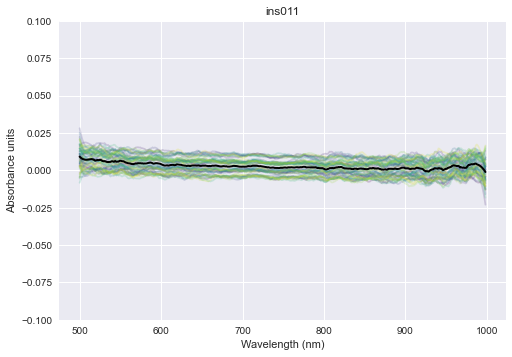

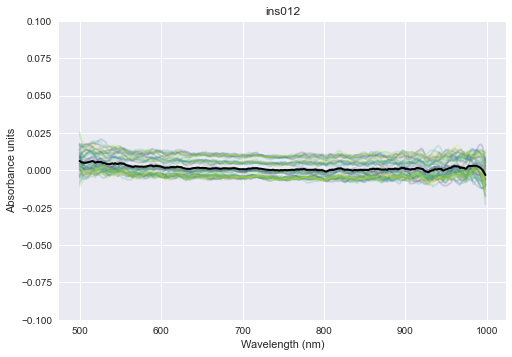

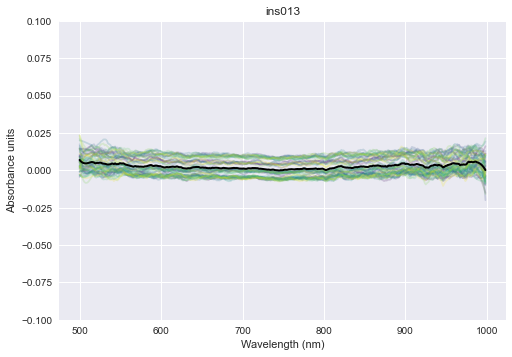

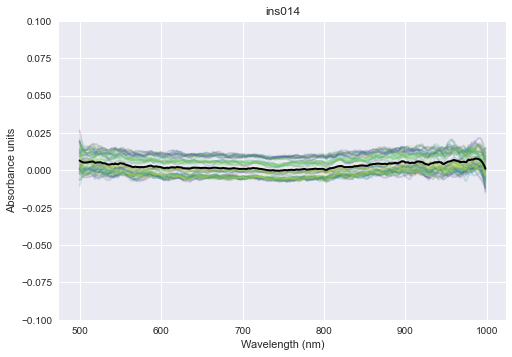

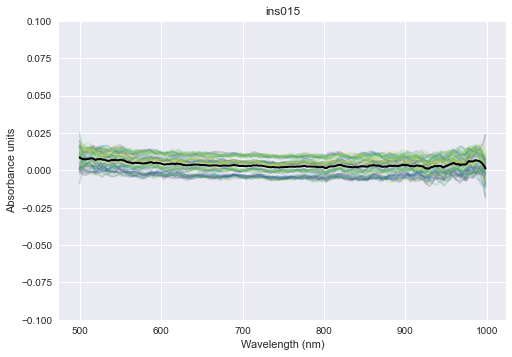

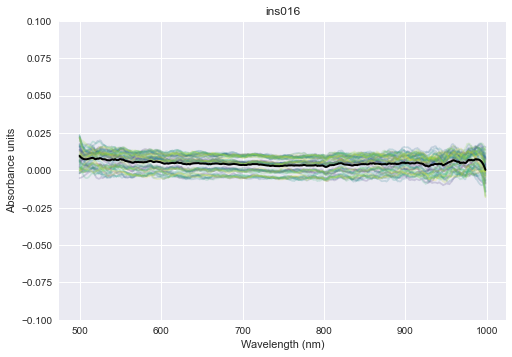

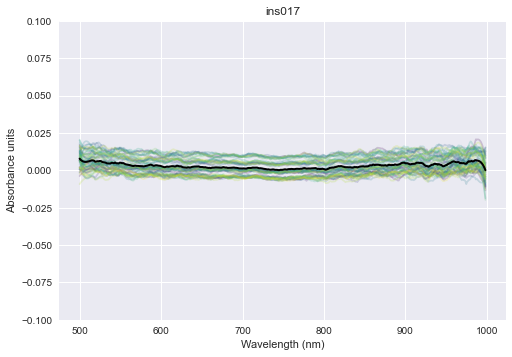

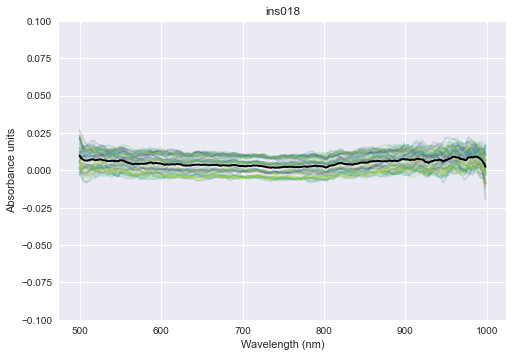

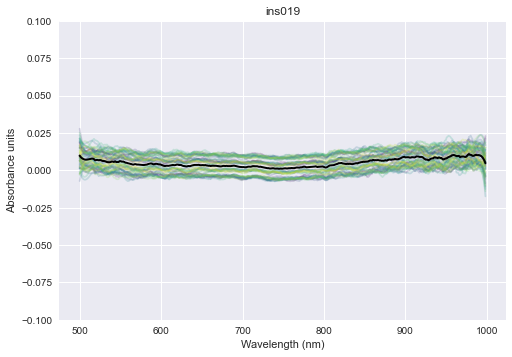

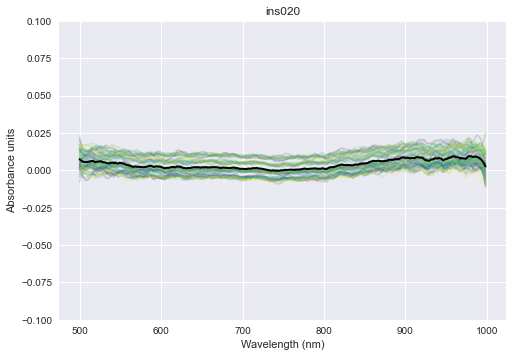

In [27]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        vis_waves = get_visible_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(vis_waves, 500)
        end_index = find_position_in_wavelength_vector(vis_waves, 1000)
        vis_raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)
        absorbance_spectra = np.empty_like(vis_raw_spectra[:, start_index:end_index], dtype=np.double)
        vis_white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
        vis_dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        fig, ax = plt.subplots()
        first_timestamp = get_visible_spectrum_timestamp(file, insertion_path, 0)
        insertion_df = pd.DataFrame()
        for i in range(vis_raw_spectra.shape[0]):
            absorbance_spectrum = savgol_filter(calculate_absorbance_from_raw(vis_raw_spectra[i, start_index:end_index], vis_white_spectrum, vis_dark_spectrum), 21, 3)
            max_absorbance = abs(absorbance_spectrum.max())
            spectrum_timestamp = get_visible_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            absorbance_spectra[i, :] = absorbance_spectrum
            color = plt.cm.viridis(normalize(i, vis_raw_spectra.shape[0], 0))
            
            ax.plot(vis_waves[start_index:end_index], absorbance_spectrum, color=color, alpha=0.2)
        ax.plot(vis_waves[start_index:end_index], absorbance_spectra.mean(axis=0), 'k', lw=2)
        ax.set_title(insertion)
        ax.set_ylabel("Absorbance units")
        ax.set_xlabel("Wavelength (nm)")
        ax.set_ylim(-0.1, 0.1)
        plt.show()
        plt.close()

# Plot wavelength of maximum absorbance, FTIR engine, 4/26/21 morning spectra

The wavelength of the maximum value of the absolute value of the absorbance spectrum are plotted by the time elapsed since the first spectrum of the the insertion.

If there is no wavelength dependence, the wavelength of the maximum absorbance would be expected to lie at the ends of the spectrum acquired because that is where there is higher noise.

The first sequence of insertions, where the light source was warming up, show the development of a peak in absorbance around 800 nm.

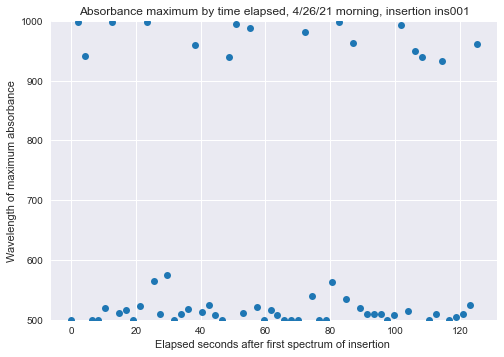

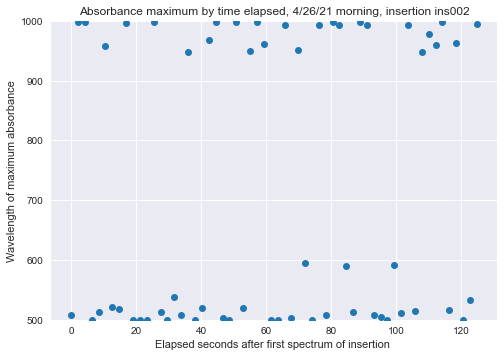

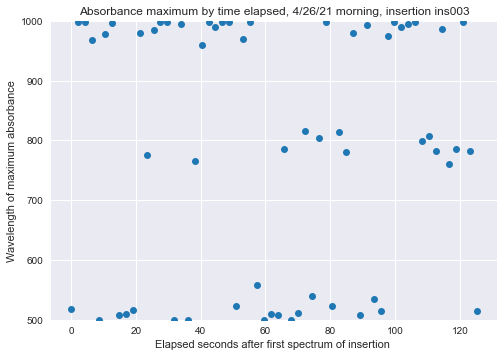

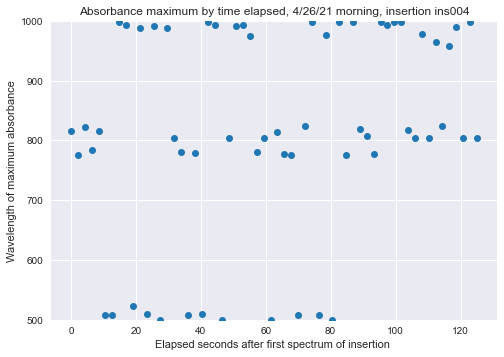

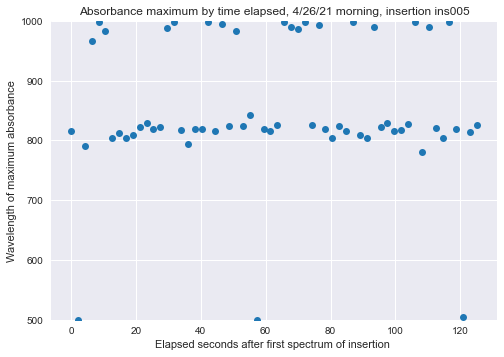

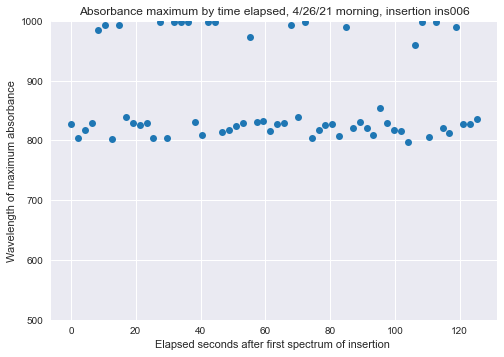

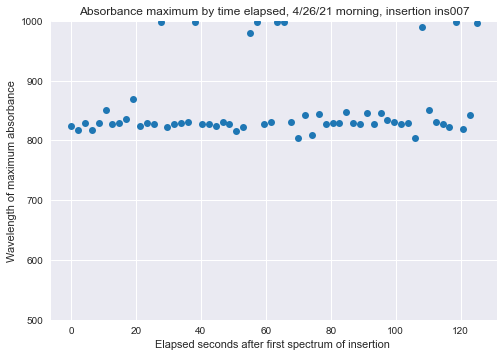

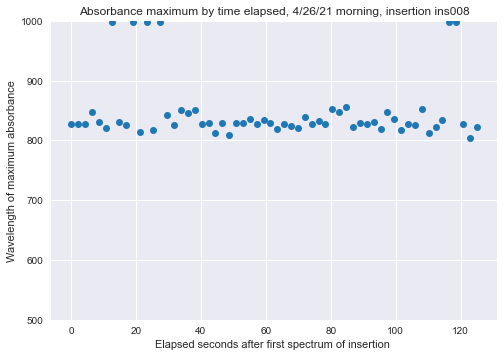

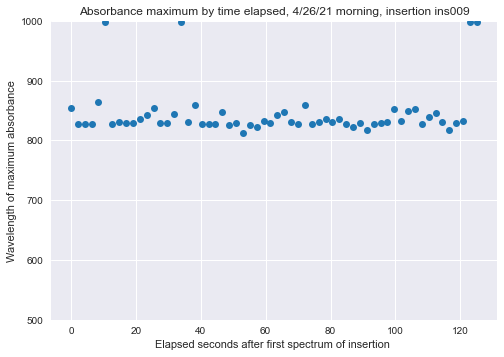

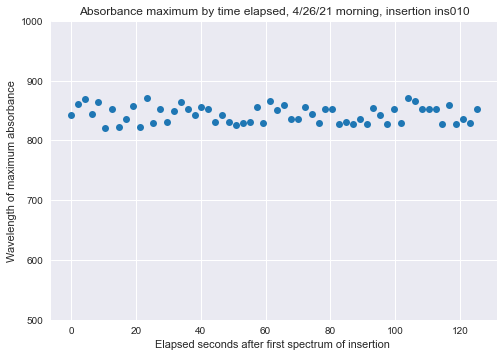

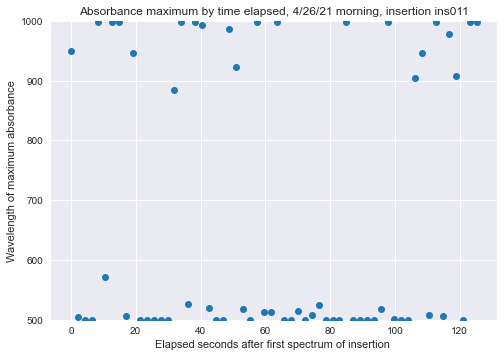

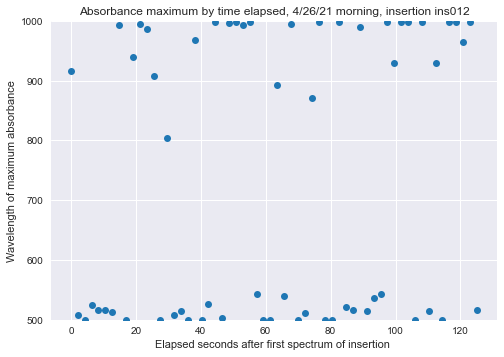

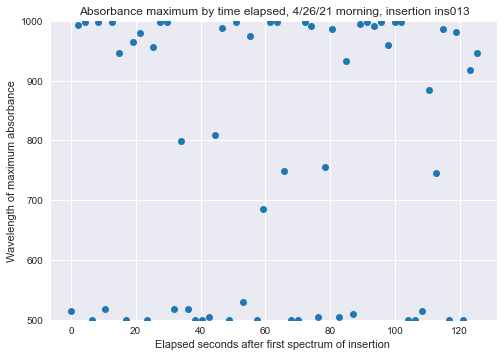

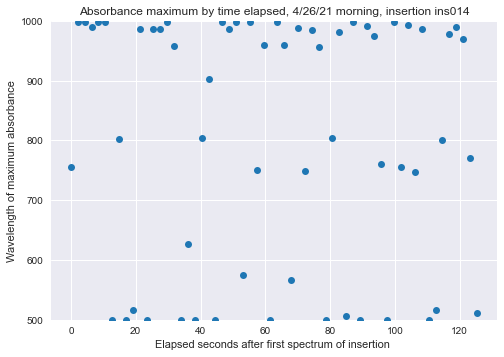

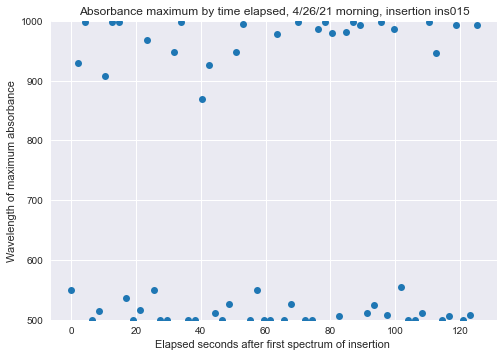

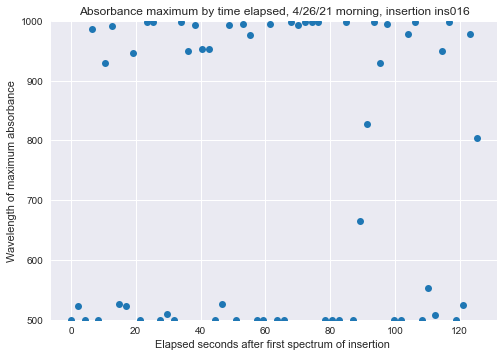

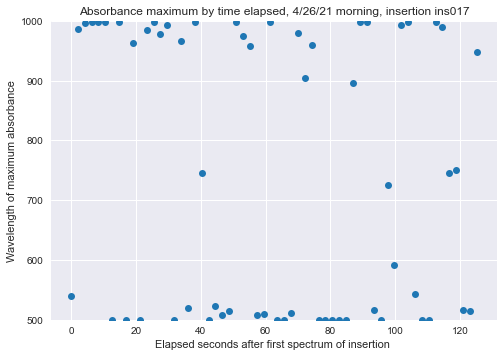

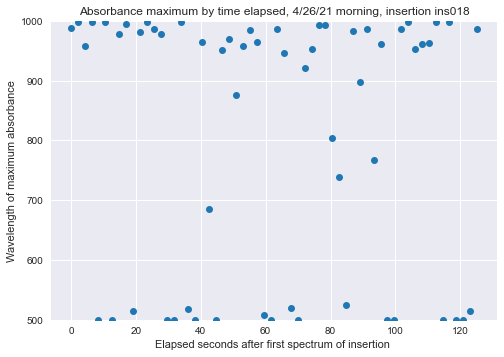

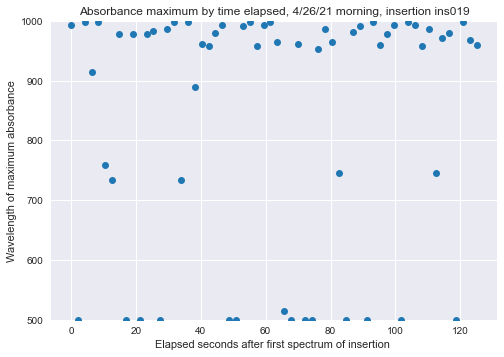

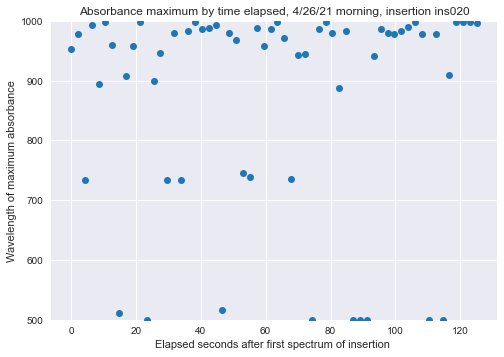

In [28]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    for index in small_df.index:    
        file = construct_full_file_path(path_name, small_df['file_name'][index])
        calibration_path = small_df['session'][index] + '/' + small_df['calibration'][index]
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        vis_waves = get_visible_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(vis_waves, 500)
        end_index = find_position_in_wavelength_vector(vis_waves, 1000)
        vis_raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)
        vis_white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
        vis_dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        fig, ax = plt.subplots()
        first_timestamp = get_visible_spectrum_timestamp(file, insertion_path, 0)
        insertion_df = pd.DataFrame()
        for i in range(vis_raw_spectra.shape[0]):
            absorbance_spectrum = savgol_filter(calculate_absorbance_from_raw(vis_raw_spectra[i, start_index:end_index], vis_white_spectrum, vis_dark_spectrum), 21, 3)
            max_absorbance = abs(absorbance_spectrum).max()
            try:
                max_absorbance_position = np.where(np.isclose(absorbance_spectrum, max_absorbance))[0][0]
            except:
                max_absorbance_position = np.where(np.isclose(absorbance_spectrum, -max_absorbance))[0][0]
            wavelength_max = vis_waves[start_index:end_index][max_absorbance_position]            
            spectrum_timestamp = get_visible_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            insertion_df.loc[i, "wavelength_max"] = wavelength_max
            
        ax.plot(insertion_df["time_delta"], insertion_df["wavelength_max"], 'o')
        ax.set_title(f'Absorbance maximum by time elapsed, 4/26/21 morning, insertion {insertion}')
        ax.set_ylabel('Wavelength of maximum absorbance')
        ax.set_xlabel('Elapsed seconds after first spectrum of insertion ')
        ax.set_ylim(500, 1000)
        plt.show()
        plt.close()

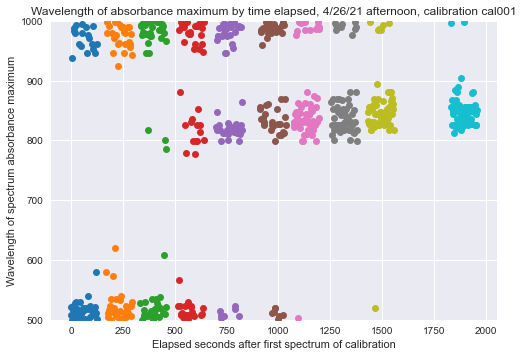

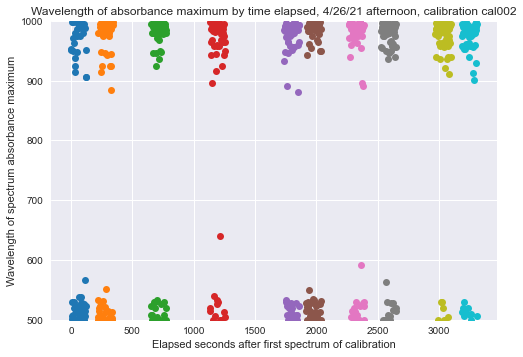

In [34]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
for calibration in this_morning_df['calibration'].unique():
    fig, ax = plt.subplots()
    small_df = this_morning_df.loc[this_morning_df['calibration'] == calibration].copy()
    file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
    calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
    calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
    
    first_timestamp = get_visible_spectrum_timestamp(file, calibration_insertions[0], 0)
    for index in small_df.index:  
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_start = get_insertion_timestamp(file, insertion_path)
        vis_waves = get_visible_wavelength_vector(file, calibration_path)
        start_index = find_position_in_wavelength_vector(vis_waves, 500)
        end_index = find_position_in_wavelength_vector(vis_waves, 1000)
        vis_raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)
        vis_white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
        vis_dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
        
        
        insertion_df = pd.DataFrame()
        for i in range(vis_raw_spectra.shape[0]):
            absorbance_spectrum = calculate_absorbance_from_raw(vis_raw_spectra[i, start_index:end_index], vis_white_spectrum, vis_dark_spectrum)
            max_absorbance = abs(absorbance_spectrum).max()
            try:
                max_absorbance_position = np.where(np.isclose(abs(absorbance_spectrum), max_absorbance))[0][0]
            except:
                max_absorbance_position = np.where(np.isclose(absorbance_spectrum, -max_absorbance))[0][0]
            wavelength_max = vis_waves[start_index:end_index][max_absorbance_position]
            spectrum_timestamp = get_visible_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()
            insertion_df.loc[i, "max_absorbance"] = max_absorbance
            insertion_df.loc[i, "wavelength_max"] = wavelength_max
            
        ax.plot(insertion_df["time_delta"], insertion_df["wavelength_max"], 'o')
    ax.set_title(f'Wavelength of absorbance maximum by time elapsed, 4/26/21 afternoon, calibration {calibration}')
    ax.set_ylabel('Wavelength of spectrum absorbance maximum')
    ax.set_xlabel('Elapsed seconds after first spectrum of calibration')

    ax.set_ylim(500, 1000)
    plt.show()
    plt.close()